In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [272]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12
from matplotlib import ticker
from matplotlib import patheffects
import numpy as np
import seaborn as sns
import xarray as xr

import covid19

def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

## data

In [273]:
#istat_path = 'comuni_giornaliero.csv'
#_, istat = covid19.data.read_istat(istat_path)

#istat_italy = istat.sel(year=2020).sum(['location', 'age_class'])
#istat_italy -= istat_italy.sel(time=slice(None, '2020-02-20')).mean()
#istat_italy = istat_italy.sel(time=slice(None, '2020-04-30'))
#istat_italy

In [274]:
# data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'

In [438]:
# data_italy_path = covid19.data.download('andamento-nazionale')
data_italy_regions_path = covid19.data.download('regioni')

In [439]:
ds_italy_regions = covid19.data.read_dpc(data_italy_regions_path)

ds_italy_regions['daily_deaths'] = ds_italy_regions['deaths'].diff('time')

ds_italy_regions['daily_deaths'].loc[{'location': 'Italy / Emilia-Romagna', 'time': '2020-08-15'}] = 0

ds_italy_regions['daily_confirmed'] = ds_italy_regions['confirmed'].diff('time')
ds_italy_regions['daily_tests'] = ds_italy_regions['tests'].diff('time')
ds_italy_regions['daily_tested'] = ds_italy_regions['tested'].diff('time')

ds_italy_regions['daily_tpr'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['daily_tests']

ds_italy_regions['mortality'] = ds_italy_regions['deaths'] / ds_italy_regions['population'] * 1_000_000

ds_italy_regions['daily_mortality'] = ds_italy_regions['daily_deaths'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_prevalence'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tests_pm'] = ds_italy_regions['daily_tests'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tested_pm'] = ds_italy_regions['daily_tested'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_severe_pm'] = ds_italy_regions['current_severe'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_critical_pm'] = ds_italy_regions['current_critical'] / ds_italy_regions['population'] * 1_000_000

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm',]:
    ds_italy_regions[kind + '7'] = ds_italy_regions[kind].rolling({'time': 7}).mean()

ds_italy_regions['daily_tpr7'] = ds_italy_regions['daily_confirmed7'] / ds_italy_regions['daily_tests7']

ds_italy_regions = ds_italy_regions.fillna(0)
ds_italy_regions = ds_italy_regions.assign_coords({'location': ('location', [l.partition(' / ')[2] for l in ds_italy_regions.location.values])})
ds_italy_regions = ds_italy_regions.drop(['lat', 'lon', 'state_region', 'country'])

ds_italy_regions = ds_italy_regions.drop(['deaths', 'confirmed', 'tests', 'tested', 'mortality'])

# ds_italy_regions = ds_italy_regions.sel(time=slice(None, '2020-07-20'))

In [440]:
tmp = ds_italy_regions.sortby(-ds_italy_regions['population']).isel(time=-1)
REGIONS = list(tmp.location.astype(str).values)
tmp.to_dataframe()  # [['daily_prevalence', 'daily_tpr']]

current_severe  current_critical  current_confirmed  \
location                                                                     
Lombardia                        5018               507             104733   
Lazio                            2317               217              41883   
Campania                         1569               175              54488   
Sicilia                          1105               148              17618   
Veneto                           1076               149              37536   
Emilia-Romagna                   1554               161              29974   
Piemonte                         3525               233              41577   
Puglia                            745               116              14233   
Toscana                          1319               197              35464   
Calabria                          212                11               3893   
Sardegna                          344                45               7048   
Liguria                          1196                77              10467   
Marche                            398                54               7998   
Abruzzo                           427                36               8032   
Friuli Venezia Giulia             215                40               5981   
Umbria                            307                49               7836   
Basilicata                         89                15               1994   
P.A. Trento                       211                11               2318   
P.A. Bolzano                      309                33               6796   
Molise                             28                 7               1242   
Valle d'Aosta                     152                11               2124   

                       population  daily_deaths  daily_confirmed  daily_tests  \
location                                                                        
Lombardia                10018806          96.0           7758.0      43716.0   
Lazio                     5898124          34.0           2432.0      26612.0   
Campania                  5839084          15.0           4181.0      21684.0   
Sicilia                   5056641          19.0           1155.0       9376.0   
Veneto                    4907529          20.0           2436.0      19131.0   
Emilia-Romagna            4448841          12.0           1756.0      18401.0   
Piemonte                  4392526          37.0           3577.0      16022.0   
Puglia                    4063888          10.0            994.0       6196.0   
Toscana                   3742437          58.0           1828.0      15086.0   
Calabria                  1965128           4.0            262.0       2874.0   
Sardegna                  1653135           2.0            184.0       1911.0   
Liguria                   1565307          24.0           1122.0       6141.0   
Marche                    1538055           1.0            653.0       3653.0   
Abruzzo                   1322247           4.0            423.0       3543.0   
Friuli Venezia Giulia     1217872           3.0            436.0       5033.0   
Umbria                     888908           6.0            496.0       3985.0   
Basilicata                 570365           0.0            226.0       1643.0   
P.A. Trento                538604           4.0            225.0       3682.0   
P.A. Bolzano               524256           2.0            249.0       1857.0   
Molise                     310449           0.0             26.0        731.0   
Valle d'Aosta              126883           1.0            129.0        554.0   

                       daily_tested  daily_tpr  daily_mortality  ...  \
location                                                         ...   
Lombardia                   23235.0   0.177464         9.581980  ...   
Lazio                       22691.0   0.091387         5.764545  ...   
Campania                    17469.0   0.192815         2.568896  ...   
Sici

In [441]:
ds_italy = ds_italy_regions.sum('location')
ds_italy['daily_mortality'] = ds_italy['daily_deaths'] / ds_italy['population'] * 1_000_000
ds_italy['daily_prevalence'] = ds_italy['daily_confirmed'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tests_pm'] = ds_italy['daily_tests'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tested_pm'] = ds_italy['daily_tested'] / ds_italy['population'] * 1_000_000
ds_italy['current_severe_pm'] = ds_italy['current_severe'] / ds_italy['population'] * 1_000_000
ds_italy['current_critical_pm'] = ds_italy['current_critical'] / ds_italy['population'] * 1_000_000

ds_italy['daily_tpr'] = ds_italy['daily_confirmed'] / ds_italy['daily_tests']

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm']:
    ds_italy[kind + '7'] = ds_italy[kind].rolling({'time': 7}).mean()

ds_italy['daily_confirmed14'] = ds_italy['daily_confirmed'].rolling({'time': 21}).mean()

ds_italy['daily_tpr7'] = ds_italy['daily_confirmed7'] / ds_italy['daily_tests7']

ds_italy.to_dataframe().tail(22)

current_severe  current_critical  current_confirmed  population  \
time                                                                          
2020-10-14            5470               539              92445    60589085   
2020-10-15            5796               586              99266    60589085   
2020-10-16            6178               638             107312    60589085   
2020-10-17            6617               705             116935    60589085   
2020-10-18            7131               750             126237    60589085   
2020-10-19            7676               797             134003    60589085   
2020-10-20            8454               870             142739    60589085   
2020-10-21            9057               926             155442    60589085   
2020-10-22            9694               992             169302    60589085   
2020-10-23           10549              1049             186002    60589085   
2020-10-24           11287              1128             203182    60589085   
2020-10-25           12006              1208             222241    60589085   
2020-10-26           12997              1284             236684    60589085   
2020-10-27           13955              1411             255090    60589085   
2020-10-28           14981              1536             276457    60589085   
2020-10-29           15964              1651             299191    60589085   
2020-10-30           16994              1746             325786    60589085   
2020-10-31           17966              1843             351386    60589085   
2020-11-01           18902              1939             378129    60589085   
2020-11-02           19840              2022             396512    60589085   
2020-11-03           21114              2225             418142    60589085   
2020-11-04           22116              2292             443235    60589085   

            daily_deaths  daily_confirmed  daily_tests  daily_tested  \
time                                                                   
2020-10-14          43.0           7332.0     152196.0       87601.0   
2020-10-15          83.0           8803.0     162932.0       98542.0   
2020-10-16          55.0          10009.0     150377.0       92402.0   
2020-10-17          47.0          10925.0     165837.0      103326.0   
2020-10-18          69.0          11705.0     146541.0       95554.0   
2020-10-19          73.0           9337.0      98862.0       65824.0   
2020-10-20          89.0          10871.0     144737.0       87680.0   
2020-10-21         127.0          15199.0     177848.0      106488.0   
2020-10-22         136.0          16078.0     170392.0      104872.0   
2020-10-23          91.0          19143.0     182032.0      114499.0   
2020-10-24         151.0          19640.0     177669.0      109673.0   
2020-10-25         128.0          21273.0     161880.0      101876.0   
2020-10-26         141.0          17007.0     124686.0       78816.0   
2020-10-27         221.0          21989.0     174398.0      106346.0   
2020-10-28         205.0          24988.0     198952.0      121820.0   
2020-10-29         217.0          26829.0     201452.0      118857.0   
2020-10-30         199.0          31079.0     215085.0      129688.0   
2020-10-31         297.0          31756.0     215886.0      132279.0   
2020-11-01         208.0          29905.0     183457.0      117478.0   
2020-11-02         233.0          22253.0     135731.0       87663.0   
2020-11-03         353.0          28241.0     182287.0      109932.0   
2020-11-04         352.0          30548.0     211831.0      127500.0   

            daily_tpr  daily_mortality  ...   daily_tests7  daily_confirmed7  \
time                                    ...                                    
2020-10-14   0.048175         0.709699  ...  120784.714286       5551.285714   
2020-10-15   0.054029         1.369884  ...  125761.000000       6172.000000   
2020-10-16   0.066559         0.907754  ...  128747.571429       6

## situation report

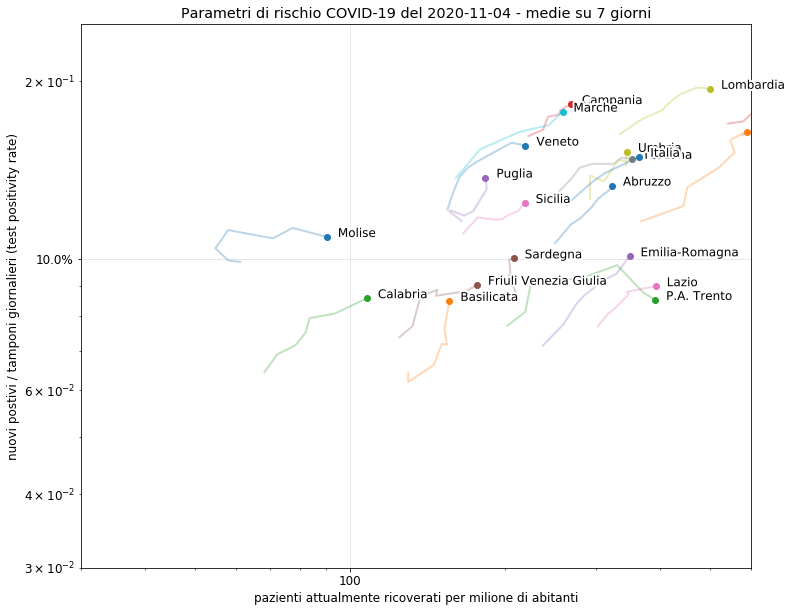

In [442]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_tpr7']
var1 = rr['current_severe_pm']

it_rr = ds_italy.isel(time=slice(-window, None))
it_var = it_rr['daily_tpr7'].expand_dims(location=['Italia'])
it_var1 = (it_rr['current_severe_pm']).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

ylim = (0.03, .25)
xlim = (30, 600)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su 7 giorni',
    xlabel='pazienti attualmente ricoverati per milione di abitanti',
    ylabel='nuovi postivi / tamponi giornalieri (test positivity rate)',
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

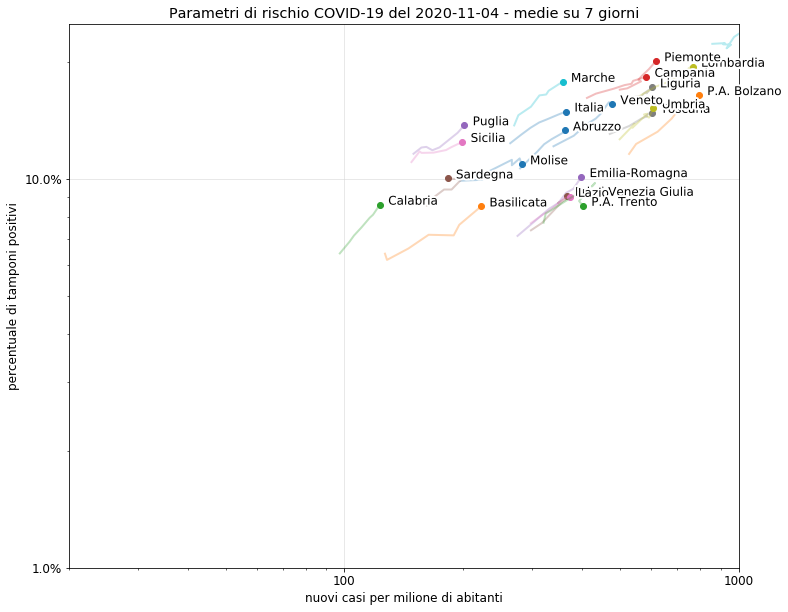

In [443]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_tpr7']
var1 = rr['daily_prevalence7']

it_rr = ds_italy.isel(time=slice(-window, None))
it_var = it_rr['daily_tpr7'].expand_dims(location=['Italia'])
it_var1 = (it_rr['current_severe_pm']).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

ylim = (0.01, .25)
xlim = (20, 1000)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su 7 giorni',
    xlabel='nuovi casi per milione di abitanti',
    ylabel='percentuale di tamponi positivi',
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

In [444]:
ds_italy_regions.sel(location="Veneto").to_dataframe()[['location', 'daily_tests', 'daily_confirmed', 'daily_deaths', 'current_severe', 'current_critical', 'daily_tested', 'daily_tests7', 'daily_confirmed7', 'daily_deaths7', 'daily_tested7', 'current_confirmed', 'daily_tpr7']].tail(20)


location  daily_tests  daily_confirmed  daily_deaths  \
time                                                              
2020-10-16   Veneto       7368.0            704.0           7.0   
2020-10-17   Veneto      14156.0            774.0           3.0   
2020-10-18   Veneto      10285.0            800.0           9.0   
2020-10-19   Veneto       4426.0            502.0          -1.0   
2020-10-20   Veneto       8126.0            490.0          13.0   
2020-10-21   Veneto      19627.0           1422.0          14.0   
2020-10-22   Veneto      14440.0           1325.0          19.0   
2020-10-23   Veneto      16277.0           1550.0           7.0   
2020-10-24   Veneto      17461.0           1729.0           9.0   
2020-10-25   Veneto      12061.0           1468.0          12.0   
2020-10-26   Veneto       7745.0           1129.0           3.0   
2020-10-27   Veneto      13688.0           1526.0          12.0   
2020-10-28   Veneto      16083.0           2143.0          11.0   
2020-10-29   Veneto      12729.0           2109.0          16.0   
2020-10-30   Veneto      21799.0           3012.0          17.0   
2020-10-31   Veneto      18117.0           2697.0          13.0   
2020-11-01   Veneto      14172.0           2300.0          17.0   
2020-11-02   Veneto       7831.0           1544.0           9.0   
2020-11-03   Veneto      11522.0           2298.0          31.0   
2020-11-04   Veneto      19131.0           2436.0          20.0   

            current_severe  current_critical  daily_tested  daily_tests7  \
time                                                                       
2020-10-16             299                40        2279.0  12003.285714   
2020-10-17             328                43        4634.0  11883.285714   
2020-10-18             378                44        3739.0  11761.142857   
2020-10-19             396                44        1951.0  11486.571429   
2020-10-20             459                51        3157.0  12068.571429   
2020-10-21             439                56        7837.0  11858.857143   
2020-10-22             500                59        5318.0  11204.000000   
2020-10-23             515                64        6030.0  12476.714286   
2020-10-24             548                68        6174.0  12948.857143   
2020-10-25             585                71        4661.0  13202.571429   
2020-10-26             612                76        3133.0  13676.714286   
2020-10-27             664                83        5523.0  14471.285714   
2020-10-28             708                90        5941.0  13965.000000   
2020-10-29             759                97        4342.0  13720.571429   
2020-10-30             777               117        7730.0  14509.428571   
2020-10-31             801               123        6100.0  14603.142857   
2020-11-01             832               132        5703.0  14904.714286   
2020-11-02             873               136        2932.0  14917.000000   
2020-11-03            1011               142        4712.0  14607.571429   
2020-11-04            1076               149        6731.0  15043.000000   

            daily_confirmed7  daily_deaths7  daily_tested7  current_confirmed  \
time                                                                            
2020-10-16        539.000000       5.000000    4558.285714               8138   
2020-10-17        569.428571       4.428571    4436.285714               8740   
2020-10-18        621.142857       5.428571    4341.285714               9425   
2020-10-19        646.000000       5.142857    4262.428571               9845   
2020-10-20        646.714286       6.000000    4454.571429              10256   
2020-10-21        756.000000       8.000000    4404.714286              11433   
2020-10-22        859.571429       9.142857    4130.714286              12608   
2020-10-23        980.428571       9.142857    4666.571429              14034   
2020-10-24       1116.857143      10.000000    4886.5

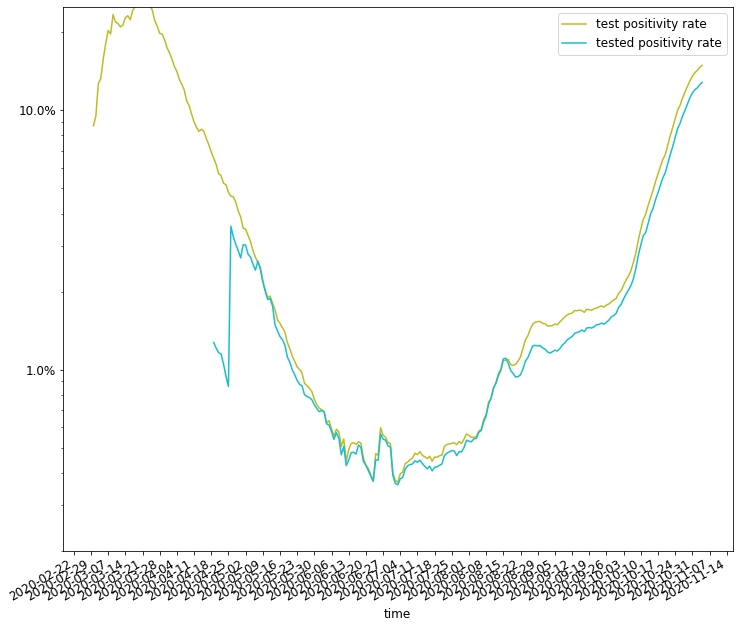

In [445]:
_, ax = plt.subplots()
ax.set(yscale='log', title='nuovi postivi / tamponi giornalieri (test positivity rate)')
covid19.plot.plot_data(ax, ds_italy['daily_tpr7'], label='test positivity rate',  marker=None)
data = ds_italy['daily_confirmed7'] / ds_italy['daily_tested7']
covid19.plot.plot_data(ax, data, label='tested positivity rate', marker=None, ratio=1.9)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.set(ylim=(0.002, 0.25))
_ = ax.legend()

In [446]:
tmp = ds_italy_regions.sel(location='Liguria').to_dataframe()
tmp['tpr'] = tmp['daily_confirmed'] / tmp['daily_tests']
tmp['tpr7'] = tmp['daily_confirmed7'] / tmp['daily_tests7']
tmp.tail(12)

current_severe  current_critical  current_confirmed  population  \
time                                                                          
2020-10-24             641                38               5760     1565307   
2020-10-25             696                41               6036     1565307   
2020-10-26             788                46               6442     1565307   
2020-10-27             837                45               6957     1565307   
2020-10-28             878                46               7478     1565307   
2020-10-29             907                50               7936     1565307   
2020-10-30             948                52               8322     1565307   
2020-10-31            1036                57               8431     1565307   
2020-11-01            1080                63               8714     1565307   
2020-11-02            1133                57               9294     1565307   
2020-11-03            1147                64               9829     1565307   
2020-11-04            1196                77              10467     1565307   

            daily_deaths  daily_confirmed  daily_tests  daily_tested  \
time                                                                   
2020-10-24           6.0           1035.0       6114.0        2951.0   
2020-10-25           5.0            657.0       4195.0        1938.0   
2020-10-26          13.0            419.0       2519.0        1034.0   
2020-10-27          14.0           1127.0       6357.0        3306.0   
2020-10-28          15.0            926.0       6340.0        2837.0   
2020-10-29           9.0           1018.0       6067.0        2882.0   
2020-10-30           7.0            999.0       6234.0        2644.0   
2020-10-31          25.0           1068.0       6389.0        2569.0   
2020-11-01           7.0            736.0       4044.0        1709.0   
2020-11-02           9.0            599.0       2846.0        1431.0   
2020-11-03          20.0           1052.0       6619.0        3215.0   
2020-11-04          24.0           1122.0       6141.0        3194.0   

            daily_tpr  daily_mortality  ...  daily_deaths7  daily_tested7  \
time                                    ...                                 
2020-10-24   0.169284         3.833114  ...       7.571429    2154.714286   
2020-10-25   0.156615         3.194262  ...       7.857143    2213.142857   
2020-10-26   0.166336         8.305080  ...       9.000000    2229.142857   
2020-10-27   0.177285         8.943932  ...      10.142857    2244.428571   
2020-10-28   0.146057         9.582785  ...      11.000000    2350.285714   
2020-10-29   0.167793         5.749671  ...       9.857143    2447.714286   
2020-10-30   0.160250         4.471966  ...       9.857143    2513.142857   
2020-10-31   0.167162        15.971308  ...      12.571429    2458.571429   
2020-11-01   0.181998         4.471966  ...      12.857143    2425.857143   
2020-11-02   0.210471         5.749671  ...      12.285714    2482.571429   
2020-11-03   0.158936        12.777046  ...      13.142857    2469.571429   
2020-11-04   0.182706        15.332456  ...      14.428571    2520.571429   

            daily_mortality7  daily_prevalence7  daily_tests_pm7  \
time                                                               
2020-10-24          4.837025         424.289202      2962.449447   
2020-10-25          5.019554         450.482146      3041.575870   
2020-10-26          5.749671         459.243550      3100.715341   
2020-10-27          6.479788         479.321765      3127.638403   
2020-10-28          7.027375         514.002319      3254.496220   
2020-10-29          6.297259         543.937114      3348.316245   
2020-10-30          6.297259         564.106594      3452.175379   
2020-10-31          8.031286         567.118326      3477.273148   
2020-11-01          8.213815         574.328231      3463.492191   
2020-11-02          7.848757         590.755862      3493.335721   
2

In [447]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

START_FIT = '2020-02-23'
STOP_FIT = '2020-04-01'

LAST_DAY = ds_italy.time[-1].values
SHOWUNTIL = LAST_DAY + 30 * DAY

EXTRAPOLATE = (np.datetime64('2020-03-01'), SHOWUNTIL)
XLIM = EXTRAPOLATE

XXX = ['daily_tests_pm7', 'daily_prevalence7', 'current_severe_pm', 'current_critical_pm', 'daily_mortality7'] 
FIT_PARAMS = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-19', '2020-10-06', None],
    'current_severe_pm': ['2020-08-13', '2020-10-06', None],
    'current_critical_pm': ['2020-08-07', '2020-10-10', None],
    'daily_mortality7': ['2020-08-19', '2020-10-12', None],
    'daily_tpr7': [],
    'daily_confirmed7': ['2020-10-06', '2020-10-19', '2020-10-21', '2020-10-23', '2020-11-01', None],
    'daily_deaths7': ['2020-10-15', '2020-10-29', None],
}
#FIT_PARAMS = {
#    'daily_tests_pm7': [],
#    'daily_prevalence7': [],
#    'current_severe_pm': [],
#    'current_critical_pm': ['2020-04-15', '2020-07-10'],
#    'daily_mortality7': ['2020-04-19', '2020-08-01'],
#    'daily_tpr7': [],
#    'daily_confirmed7': ['2020-10-06', None],
#}
RATIO = {
    'current_critical_pm': 0.165,
    'daily_mortality7': 0.013,
}
DEALY = {
    'current_critical_pm': -5,
    'daily_mortality7': -7.5,
}
LABEL = {
    'current_severe': 'pazienti attualmente ricoverati in reparto',
    'current_confirmed': 'attualmente positivi',
    'current_severe_pm': 'pazienti attualmente ricoverati in reparto',
    'current_critical': 'pazienti attualmente in terapia intensiva',
    'current_critical_pm': 'pazienti attualmente in terapia intensiva',
    'daily_tests7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_deaths': 'decessi giornalieri',
    'daily_deaths7': 'decessi giornalieri (media su 7 giorni)',
    'daily_confirmed7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_prevalence7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_tpr7': 'percentuale di test positivi (media su 7 giorni)',
    'daily_prevalence_screening7': 'nuovi casi da screening (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_mortality7': 'decessi giornalieri (media su 7 giorni)',
}

In [448]:
fits = {}
for kind, breaks in FIT_PARAMS.items():
    if isinstance(breaks, int):
        breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in FIT_PARAMS['current_severe']]
    fits[kind] = covid19.fit.fit_exponential_segments(ds_italy[kind], breaks=breaks, min_value=0, valid_ratio=0.4)

fits['daily_deaths7'] = [fit.shift(7).scale(0.013) for fit in fits['daily_confirmed7']]

fits

skipping start=2020-10-19T00:00:00 stop=2020-10-20T00:00:00
skipping start=2020-10-21T00:00:00 stop=2020-10-22T00:00:00
skipping start=2020-11-01T00:00:00 stop=None


{'daily_tests_pm7': [],
 'daily_prevalence7': [ExponentialFit(t_0=numpy.datetime64('2020-06-13T03:14:21'), T_d=numpy.timedelta64(1790025,'s'), r2=0.9666131919714918, start=numpy.datetime64('2020-07-19T00:00:00.000000000'), stop=numpy.datetime64('2020-10-05T00:00:00.000000000')),
  ExponentialFit(t_0=numpy.datetime64('2020-08-23T20:24:22'), T_d=numpy.timedelta64(678165,'s'), r2=0.9953844912533216, start=numpy.datetime64('2020-10-06T00:00:00.000000000'), stop=numpy.datetime64('2020-11-04T00:00:00.000000000'))],
 'current_severe_pm': [ExponentialFit(t_0=numpy.datetime64('2020-05-21T10:51:19'), T_d=numpy.timedelta64(1983649,'s'), r2=0.9939311747155095, start=numpy.datetime64('2020-08-13T00:00:00.000000000'), stop=numpy.datetime64('2020-10-05T00:00:00.000000000')),
  ExponentialFit(t_0=numpy.datetime64('2020-08-06T22:02:52'), T_d=numpy.timedelta64(898144,'s'), r2=0.9982504675900421, start=numpy.datetime64('2020-10-06T00:00:00.000000000'), stop=numpy.datetime64('2020-11-04T00:00:00.000000000

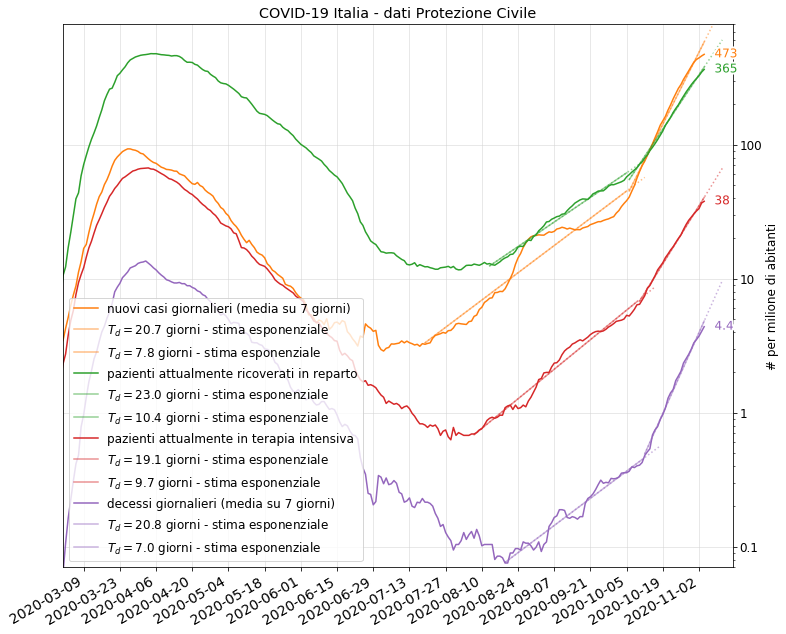

In [449]:
SHOW = ['daily_prevalence7', 'current_severe_pm', 'current_critical_pm', 'daily_mortality7']

EXTRAPOLATE = (np.datetime64('2020-03-01'), np.datetime64('2020-11-15'))
XLIM = EXTRAPOLATE

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.07, 800)})

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    if SHOW is not None and kind not in SHOW:
        continue
    label = LABEL.get(kind, '')
    ratio = RATIO.get(kind, 1.)
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=14, marker=None, annotate=True)
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7], alpha=0.5)

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)
    
_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
_ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = ax.legend(loc='lower left')

[26800, 31100, 31800, 29900, 22300, 28200, 30500, 86800, 52200, 54600, 54600, 49000, 57200, 61800]
[37225.0, 40248.0, 43517.0, 47051.0, 50873.0, 55004.0, 59471.0]
[37225.0, 40248.0, 43517.0, 47051.0, 50873.0, 55004.0, 59471.0]


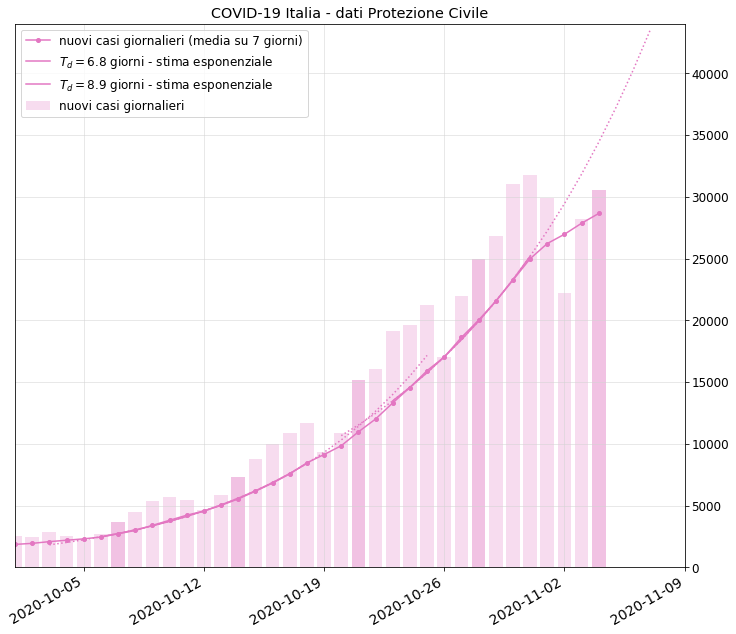

In [470]:
SHOW = ['daily_confirmed7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-11-09')), 'ylim': (0, 44000)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(ds_italy.time, ds_italy[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        ax.bar(ds_italy.time[2::7], ds_italy[kind[:-1]][2::7], color=color, alpha=0.25)
    except:
        pass
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

# ax.plot([np.datetime64('2020-10-27') + i * DAY for i in range(1, 8)], [26400, 28300, 32400, 34000, 36900, 34000, 40400], ' x', color=color, label='nuovi casi giornalieri nello scenario del 2020-10-28')

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = list(ds_italy['daily_confirmed'][-7:].values)
for i in range(1, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(round(mean))
    values.append(round(mean * 7 - sum(values[-6:])))
print([int(round(v / 100)) * 100 for v in values])
print(means)
print([round(sum(values[i:i + 7]) / 7) for i in range(1, 8)])

[5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 11, 12, 13, 14, 16, 17, 18, 20, 21, 23, 25, 27, 29, 31, 34, 37, 40, 43, 46, 50, 54, 59, 64, 69, 74, 80, 87, 94, 102, 110, 119, 128, 139, 150, 162, 175, 190, 205, 222, 240, 259, 280, 303, 328, 354, 383, 414, 448]
[2, 3, 3, 3, 3, 4, 4, 17, 6, 6, 6, 7, 8, 8, 22, 11, 12, 12, 13, 15, 16, 30, 20, 22, 22, 24, 27, 29, 44, 36, 38, 40, 44, 47, 52, 68, 63, 67, 70, 78, 83, 91, 110, 109, 116, 124, 135, 146, 158, 183, 188, 201, 217, 234, 254, 275, 309, 324, 348, 376, 407, 440, 476, 527, 559]


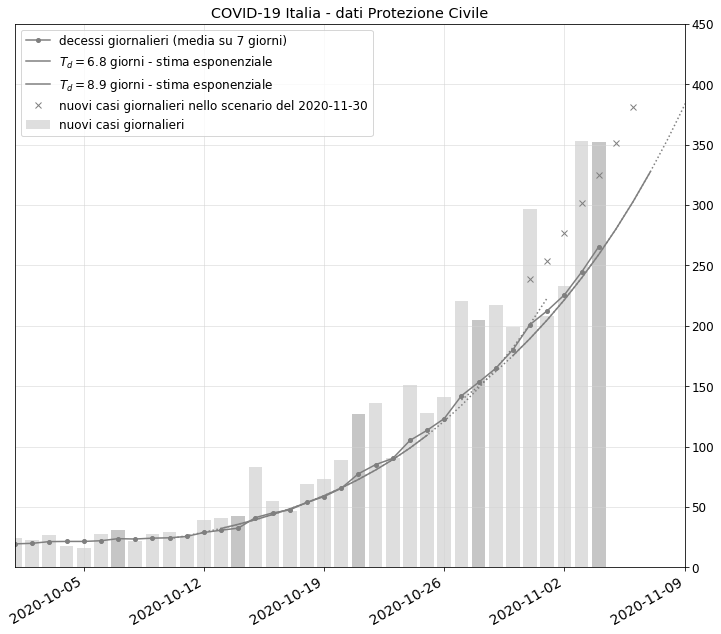

In [469]:
SHOW = ['daily_deaths7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-11-09')), 'ylim': (0, 450)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(ds_italy.time, ds_italy[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        ax.bar(ds_italy.time[2::7], ds_italy[kind[:-1]][2::7], color=color, alpha=0.25)
    except:
        pass
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

ax.plot([np.datetime64('2020-10-30') + i * DAY for i in range(1, 8)], [239, 254, 277, 302, 325, 351, 381], ' x', color=color, label='nuovi casi giornalieri nello scenario del 2020-11-30')

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = [2,3,3,3,3,4,4]
for i in range(-50, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(int(round(mean)))
    value = int(round(mean * 7 - sum(values[-6:])))
    values.append(value)
print(means)
print(values)

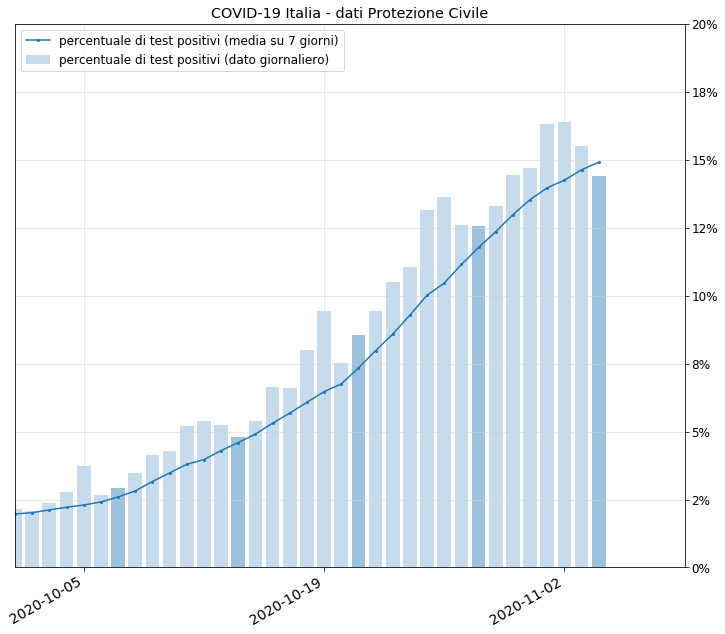

In [465]:
SHOW = ['daily_tpr7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-11-09')), 'ylim': (0, 0.20)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    color = 'tab:blue'
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=14)
    try:
        ax.bar(ds_italy.time, ds_italy[kind[:-1]], color=color, alpha=0.25, label='percentuale di test positivi (dato giornaliero)')
        ax.bar(ds_italy.time[2::7], ds_italy[kind[:-1]][2::7], color=color, alpha=0.25)
    except:
        pass
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(ylim=(0, None))

In [453]:
REGIONS_FIT_PARAMS_DEFAULT = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-10', None],
    'current_severe_pm': ['2020-07-20', None],
    'current_critical_pm': ['2020-07-25', None],
    'daily_mortality7': ['2020-09-01', None],
}
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'daily_prevalence7': ['2020-07-23', '2020-10-06', None],
        'current_severe_pm': [],
        'current_critical_pm': ['2020-08-05', '2020-10-10', None],
        'daily_mortality7': ['2020-08-01', '2020-10-15', None],
    },
    'Lazio': {
        'daily_prevalence7': ['2020-08-01', None],
        'current_severe_pm': [],
        'current_critical_pm': ['2020-08-25', None],
        'daily_mortality7': ['2020-09-05', None],
    },
    'Campania': {
    },
    'Sicilia': {
        'daily_prevalence7': ['2020-07-17', None],
        'daily_mortality7': ['2020-09-15', None],
    },
    'Veneto': {
        'daily_prevalence7': ['2020-07-10', None],
        'current_severe_pm': ['2020-08-10', None],
    },
    'Emilia-Romagna': {
        'daily_prevalence7': ['2020-06-10', None],        
    },
    'Sardegna': {
        'daily_prevalence7': ['2020-07-10', '2020-09-05', None],
        'current_severe_pm': ['2020-08-01', None],
        'current_critical_pm': [],
    },
    'Liguria': {
        'current_severe_pm': [],
    },
    'Puglia': {
        'daily_prevalence7': ['2020-07-20', '2020-09-10'],
        'current_severe_pm': ['2020-07-20', '2020-09-10'],
        'current_critical_pm': ['2020-07-25', '2020-09-20'],
    },
    'Marche':{
        'daily_prevalence7': ['2020-07-30', None],
    },
    'Basilicata': {
        'daily_prevalence7': ['2020-07-20', None],
    },
 }

STOP_FIT = '2020-04-03'

region_fits = {}
for region in REGIONS:
    params = REGIONS_FIT_PARAMS_DEFAULT.copy()
    params.update(REGIONS_FIT_PARAMS.get(region, {}))
    region_fits[region] = {}
    for kind, breaks in params.items():
        if isinstance(breaks, int):
            breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in params['current_severe']]
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds_italy_regions.sel(location=region)[kind], breaks=breaks, min_value=0, valid_ratio=1.)

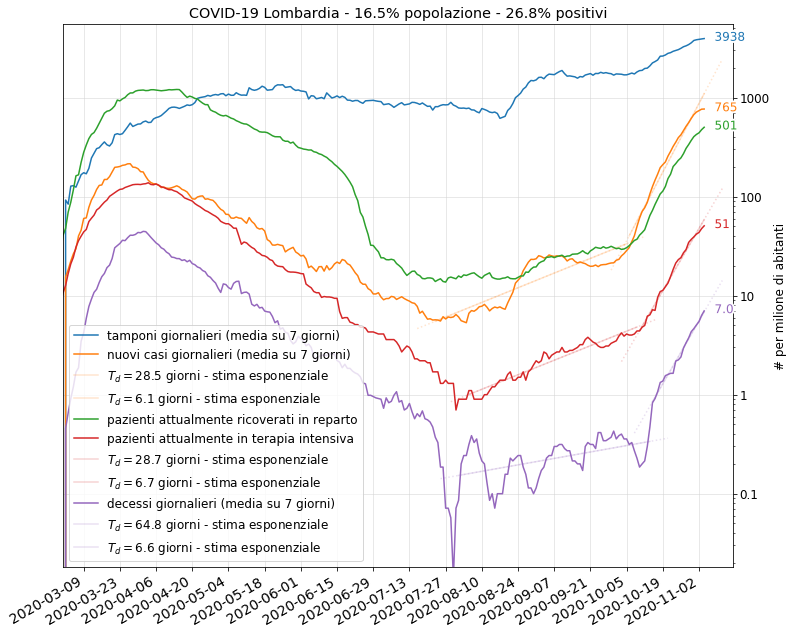

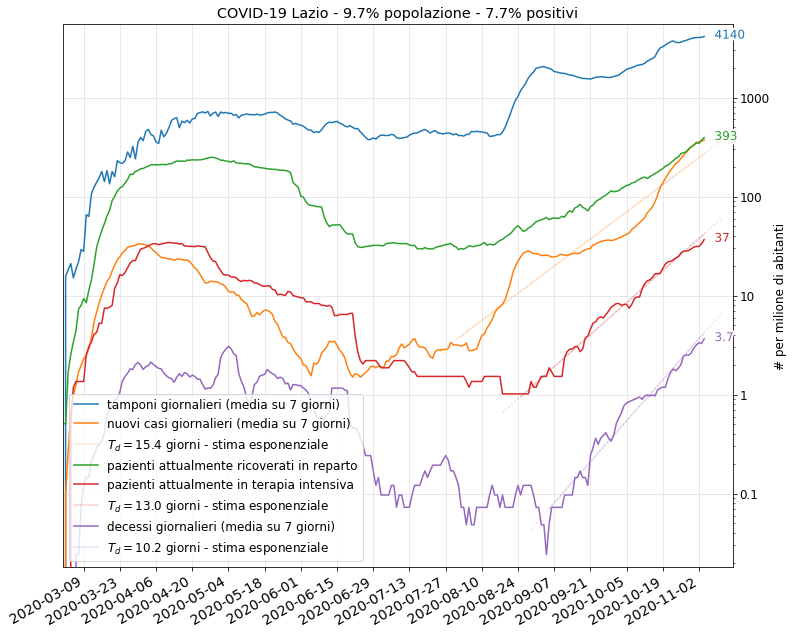

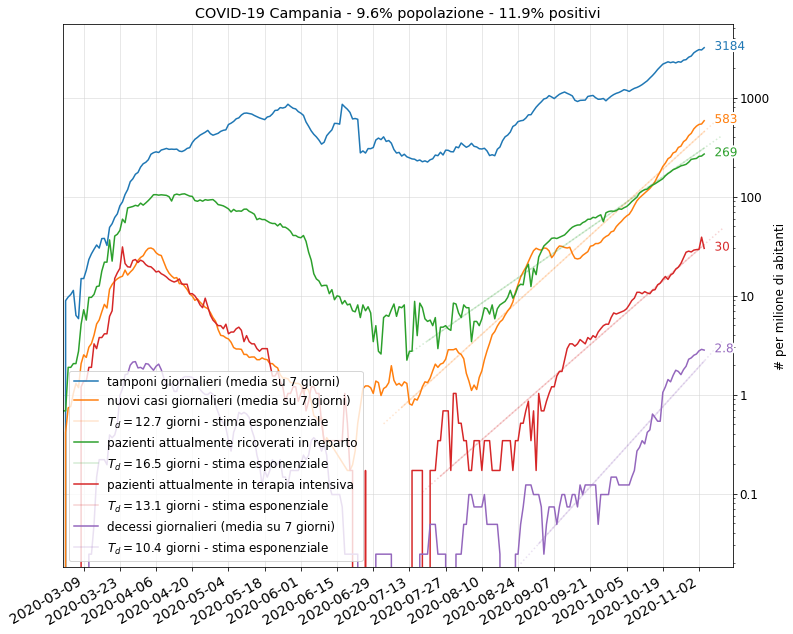

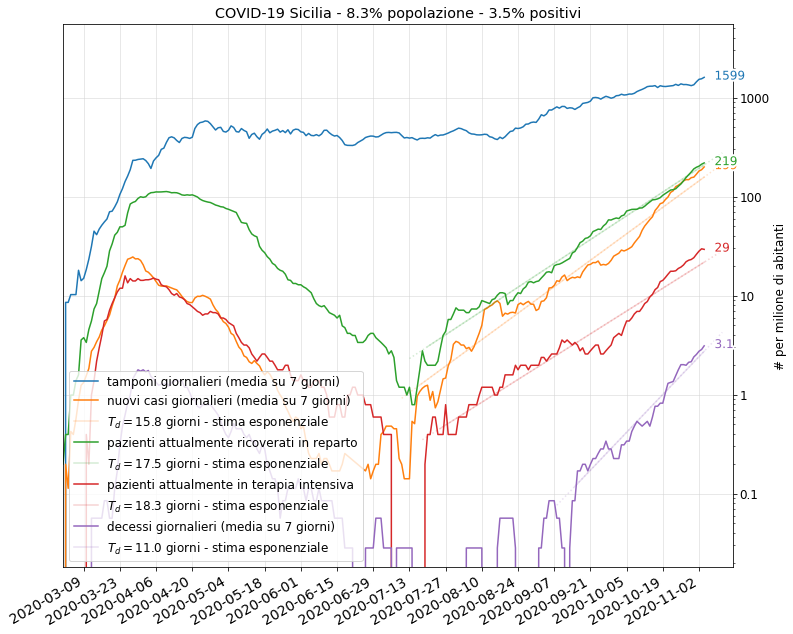

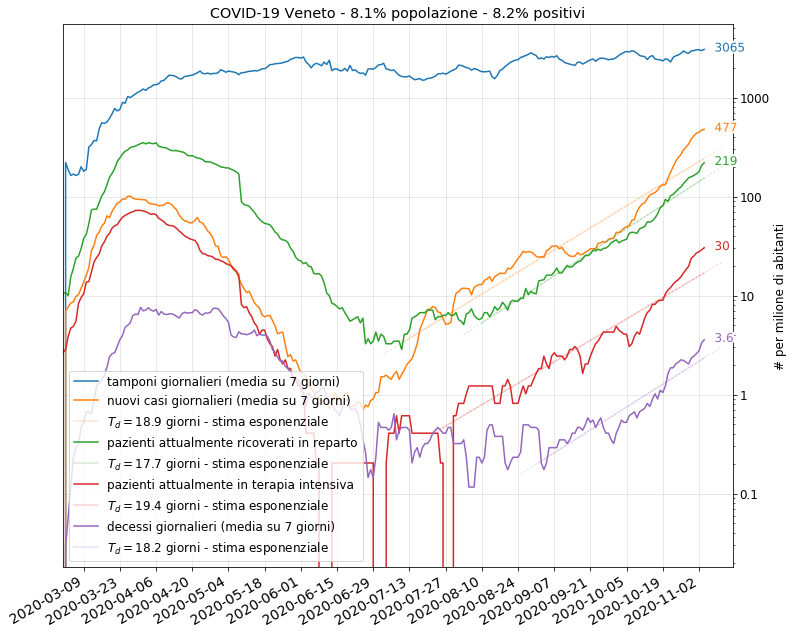

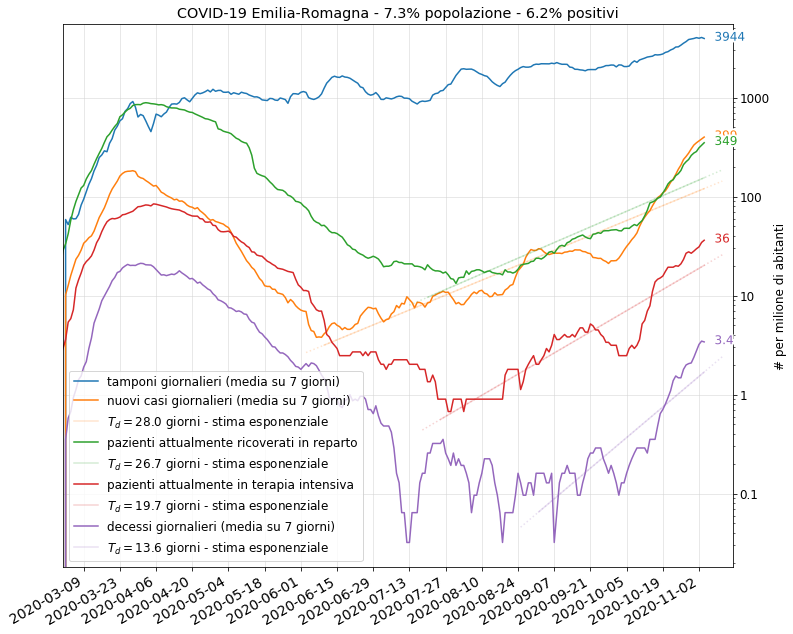

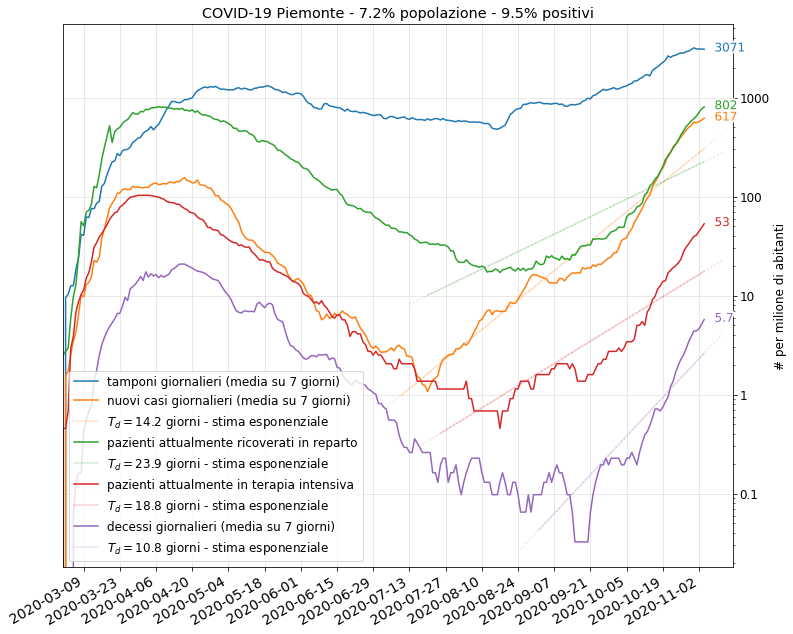

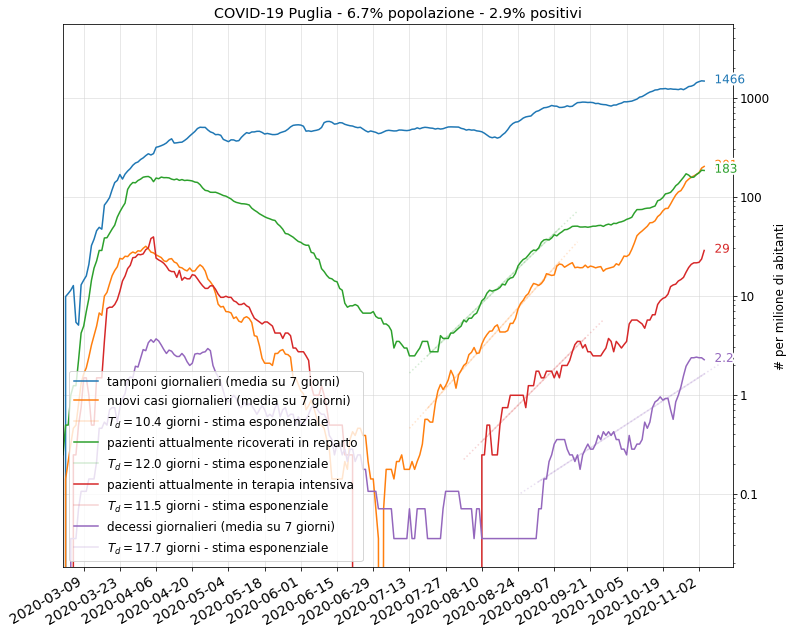

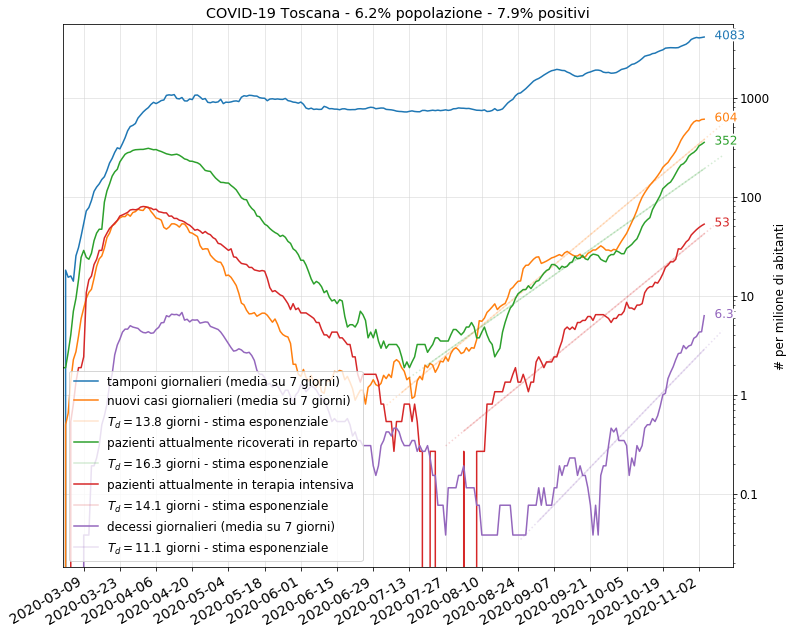

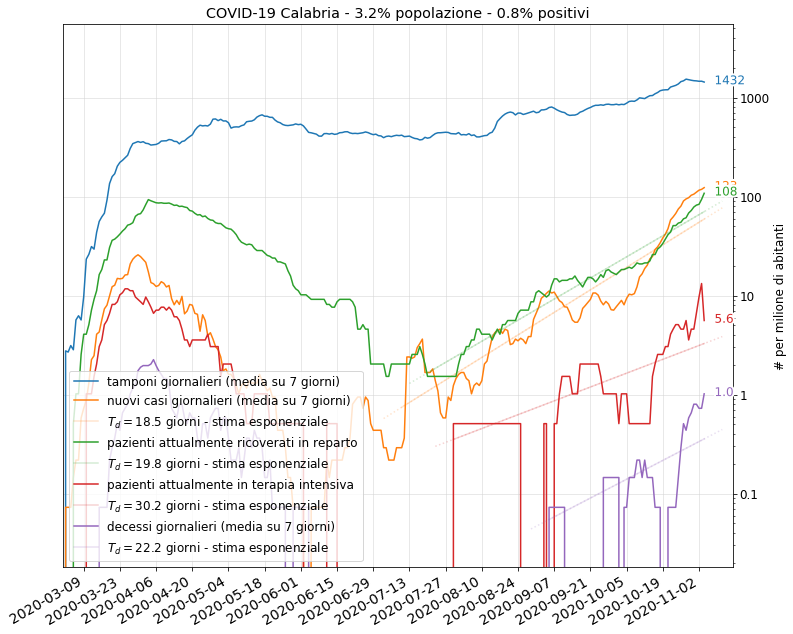

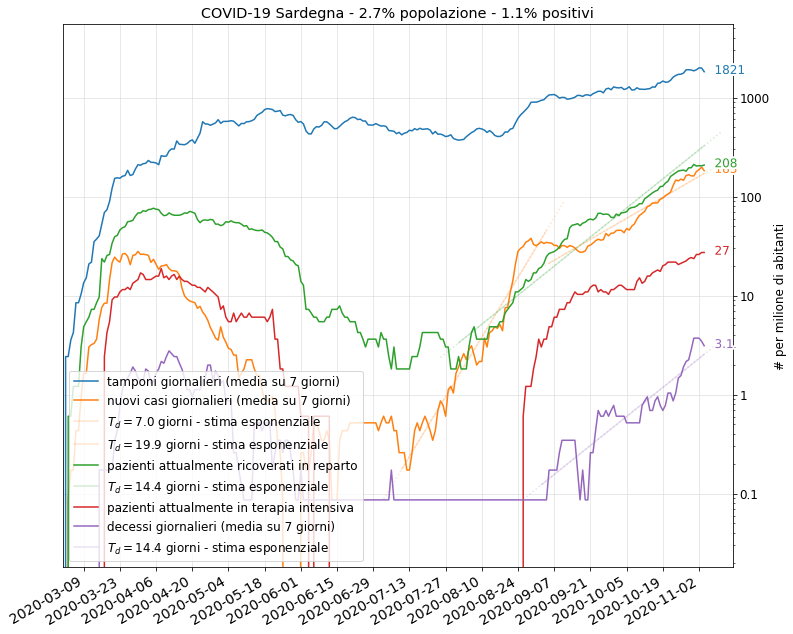

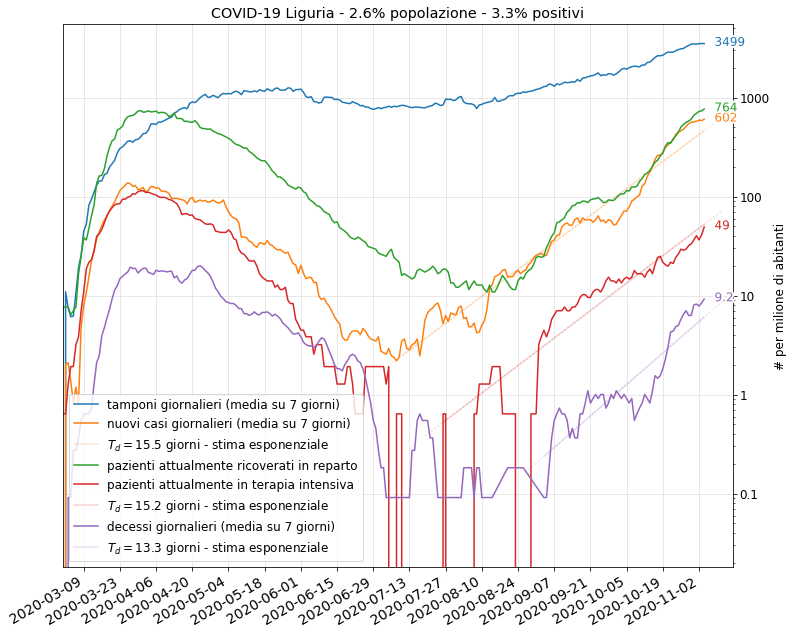

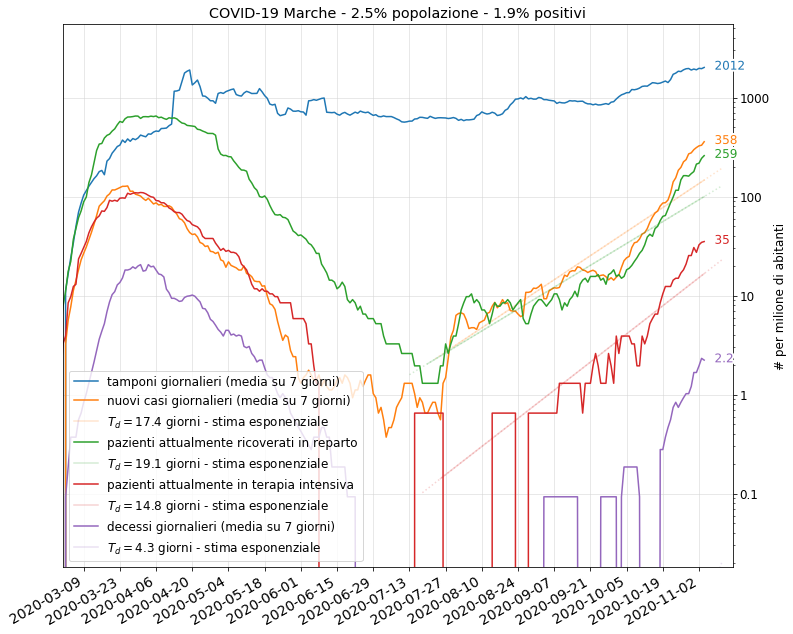

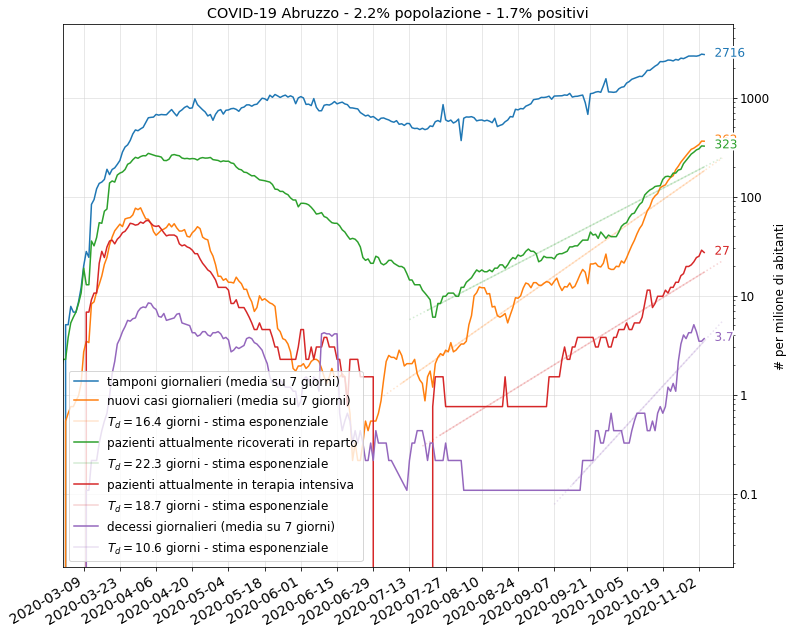

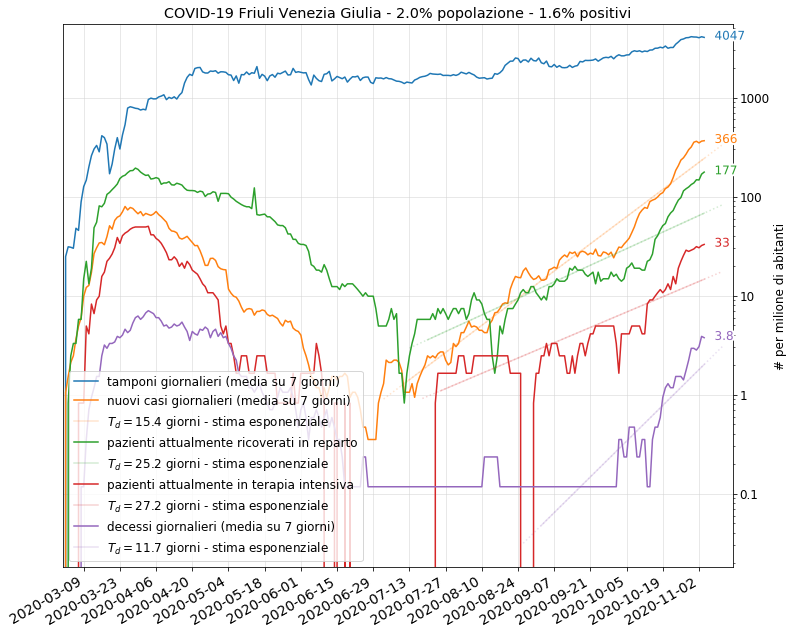

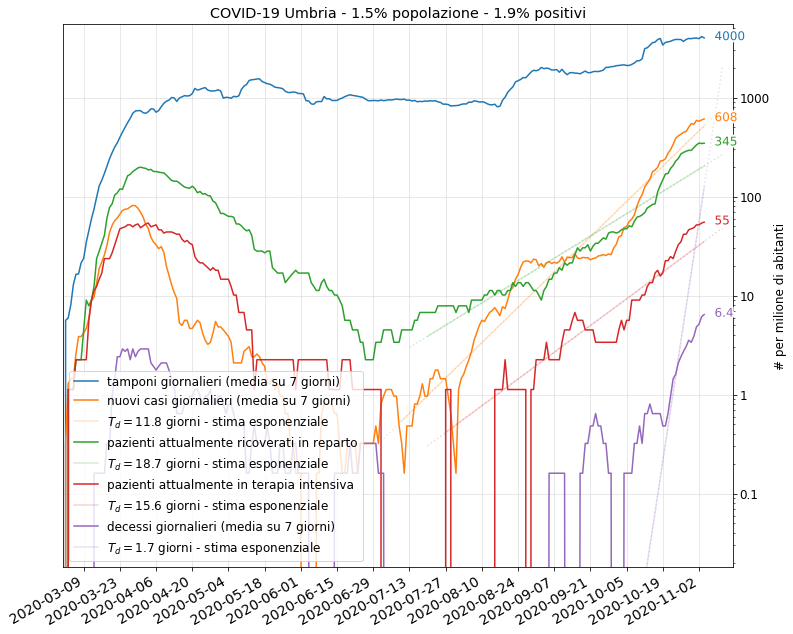

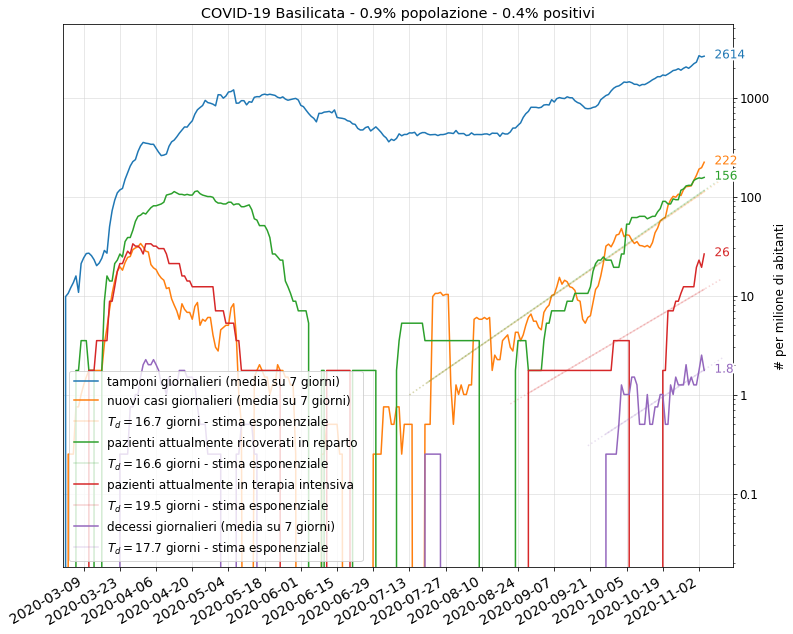

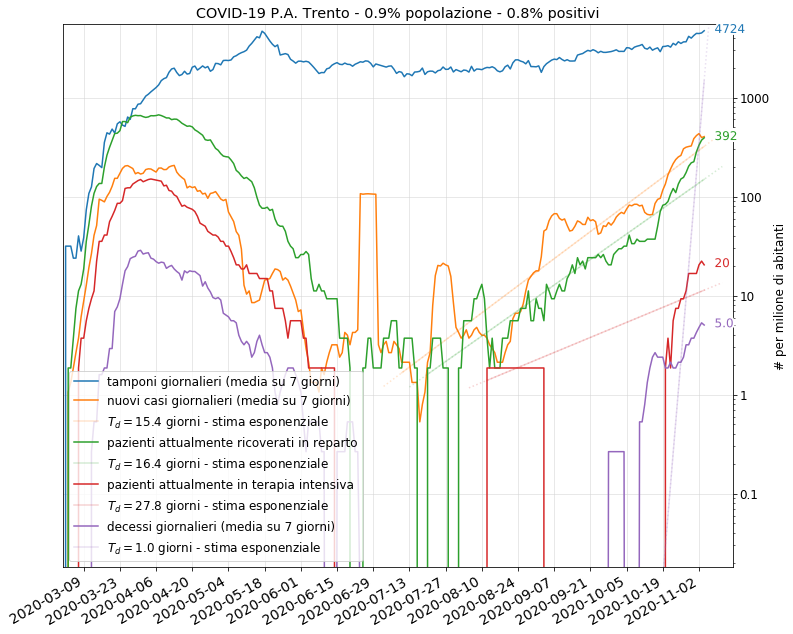

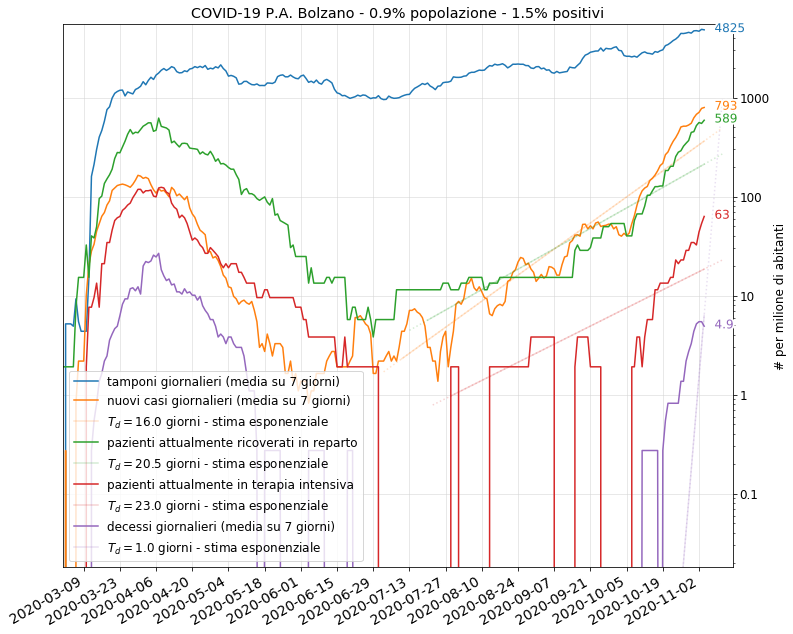

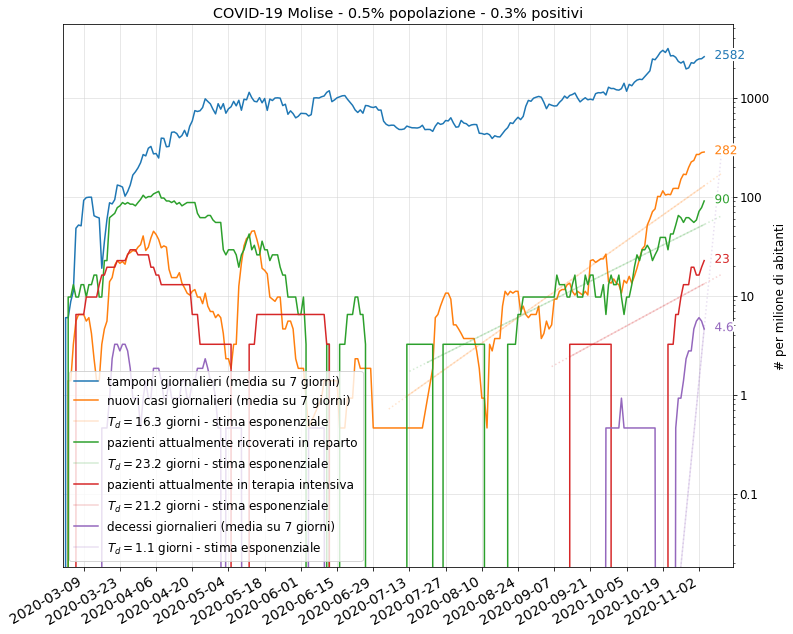

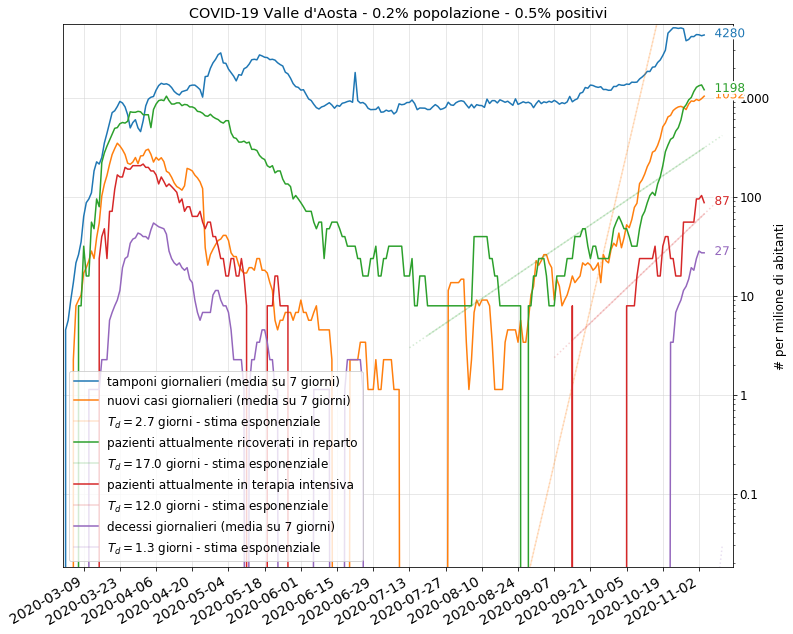

In [454]:
SHOW_REGIONS = None  # {'daily_prevalence7', 'current_severe_pm','current_critical_pm', 'daily_mortality7'}

for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.02 * 0.9, 5000 / 0.9)})
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color in zip(fit_kinds.items(), PALETTE_ONE):
        if SHOW_REGIONS is not None and kind not in SHOW_REGIONS:
            continue

        label = LABEL[kind]
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color, marker=None, date_interval=14, annotate=True)
        for fit in fitsk:
            covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-7, 7], alpha=0.2)
    pop_perc = ds_region.population.values / ds_italy.population.values * 100
    pos_perc = ds_region['daily_confirmed7'][-1].values / ds_italy['daily_confirmed7'][-1].values * 100
    ax.set_title(f'COVID-19 {region} - {pop_perc:.1f}% popolazione - {pos_perc:.1f}% positivi' )
    ax.set(xlabel="", ylabel="# per milione di abitanti")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.legend(loc='lower left')


In [455]:
EXTRAPOLATE = (np.datetime64('2020-08-01'), np.datetime64('2020-11-15'))
XLIM = EXTRAPOLATE

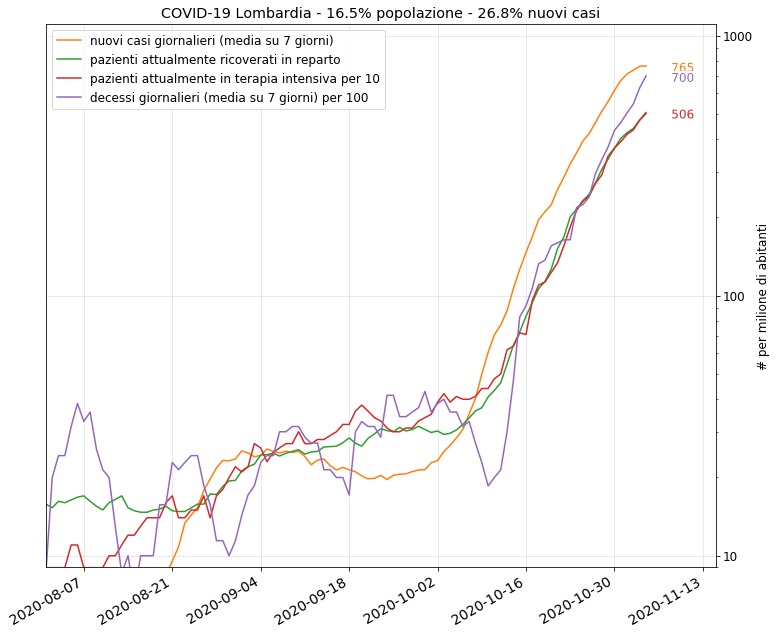

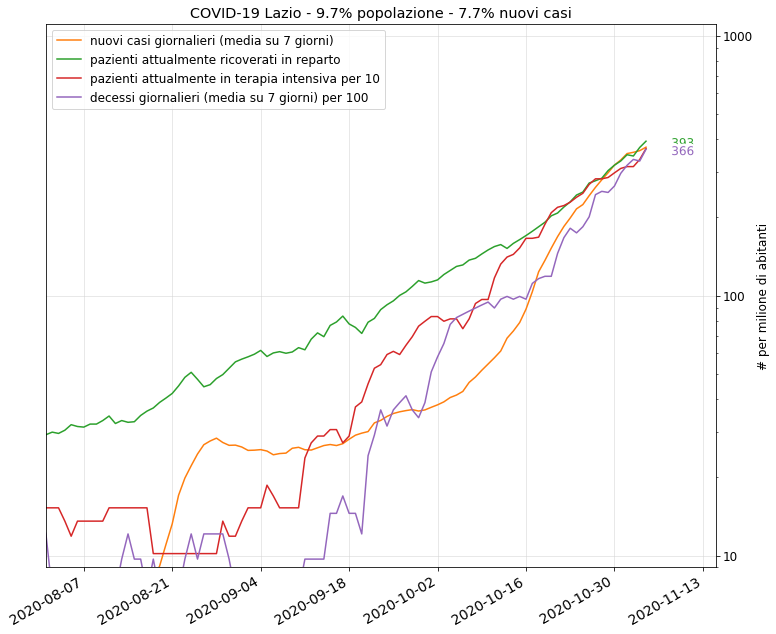

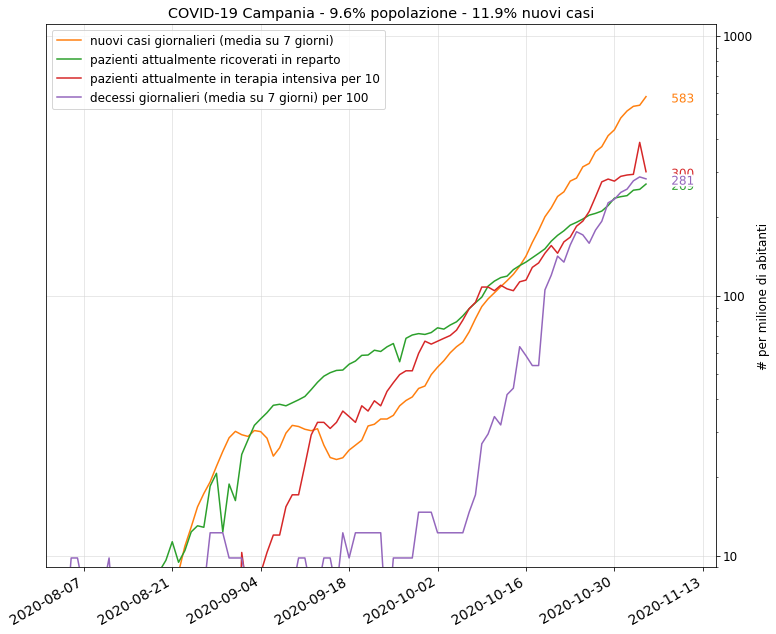

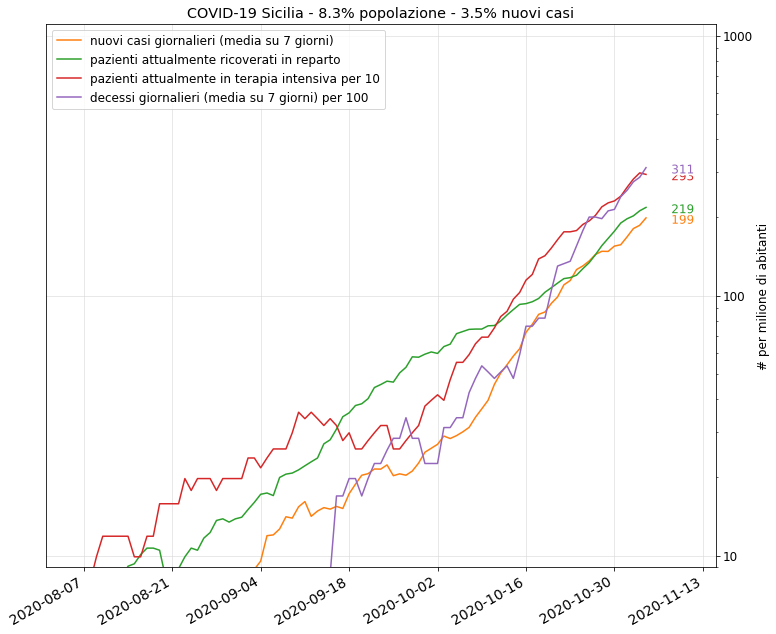

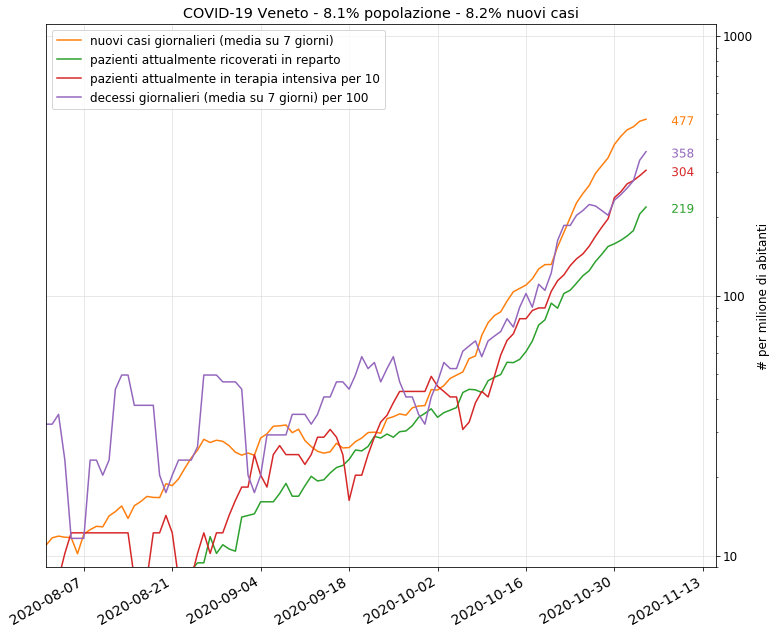

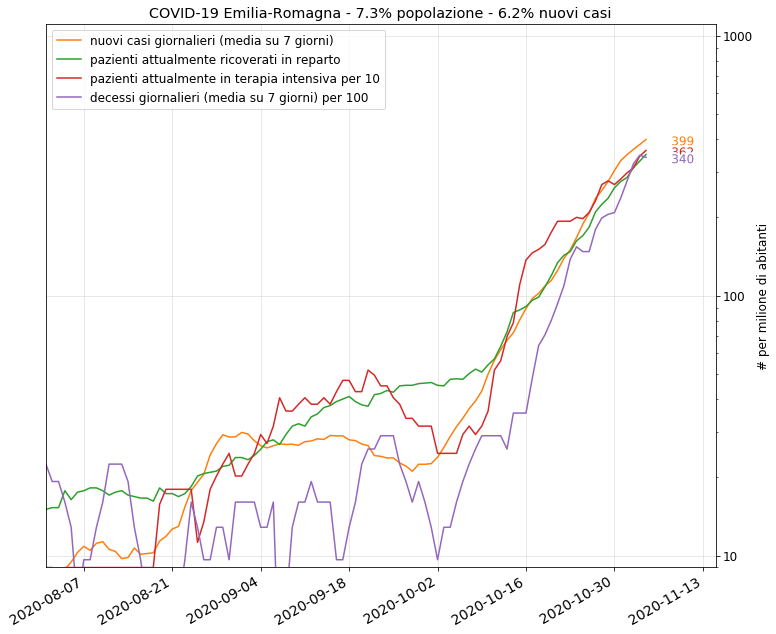

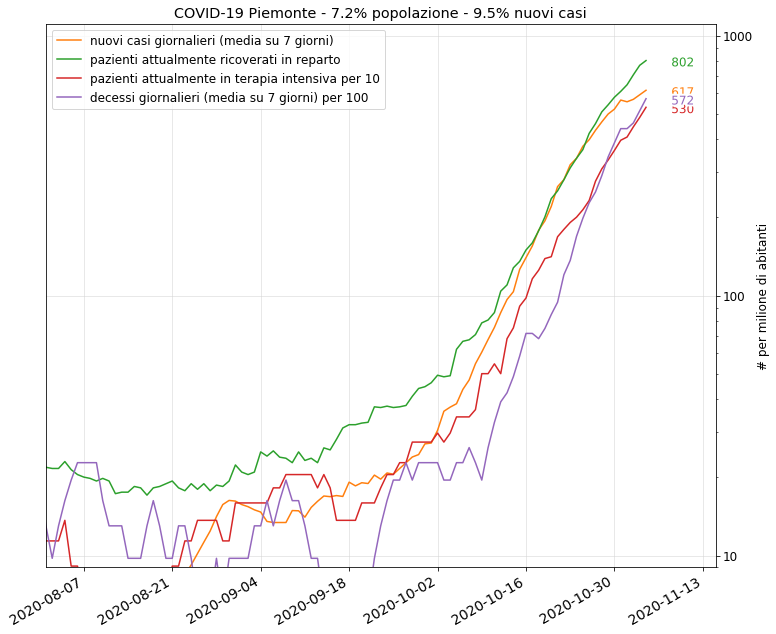

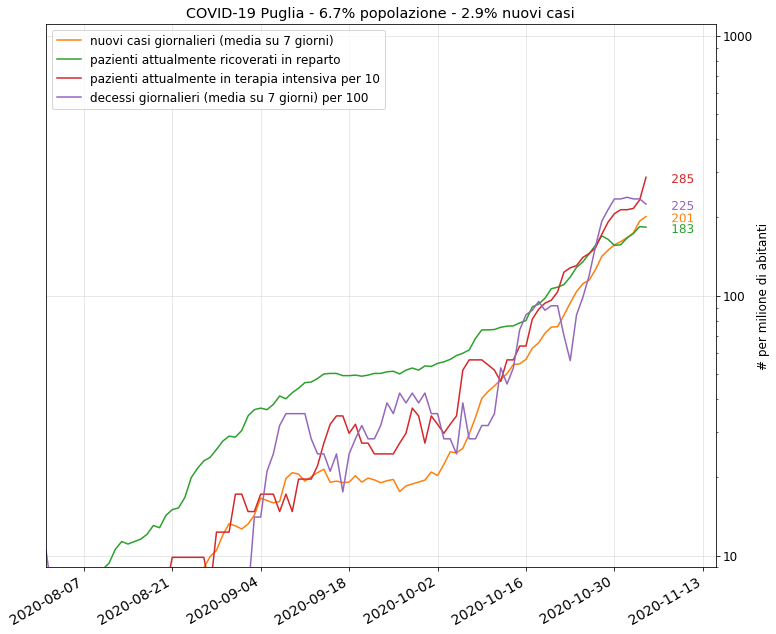

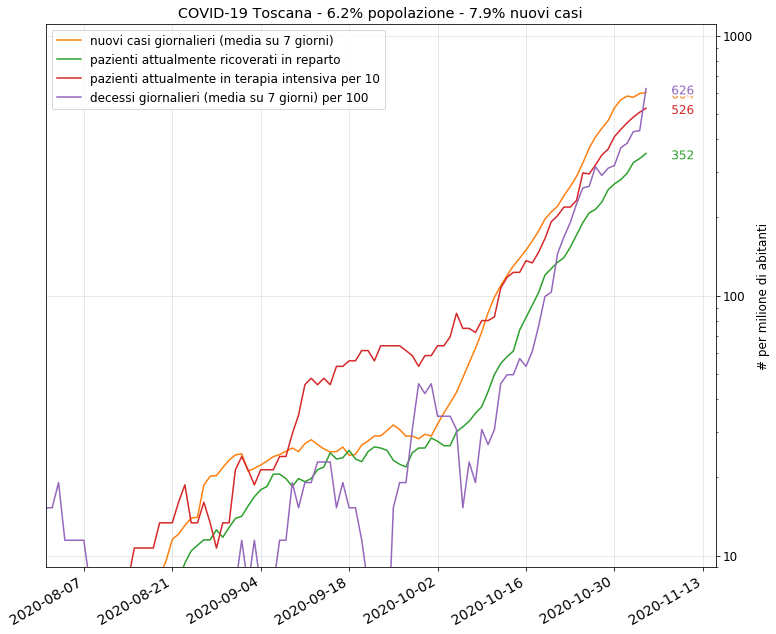

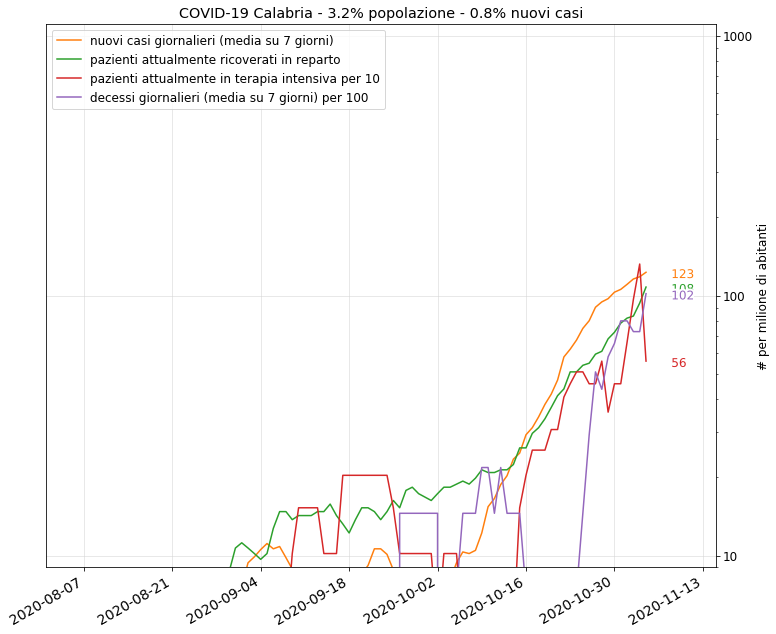

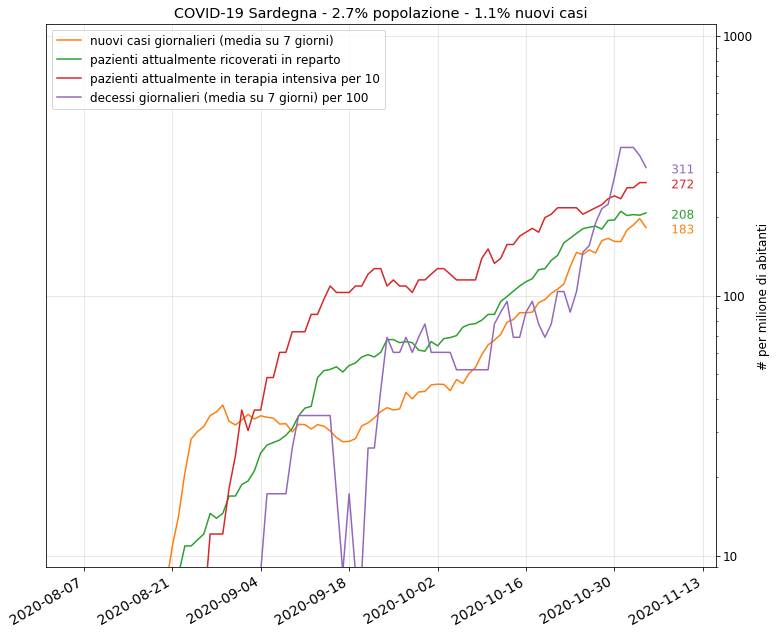

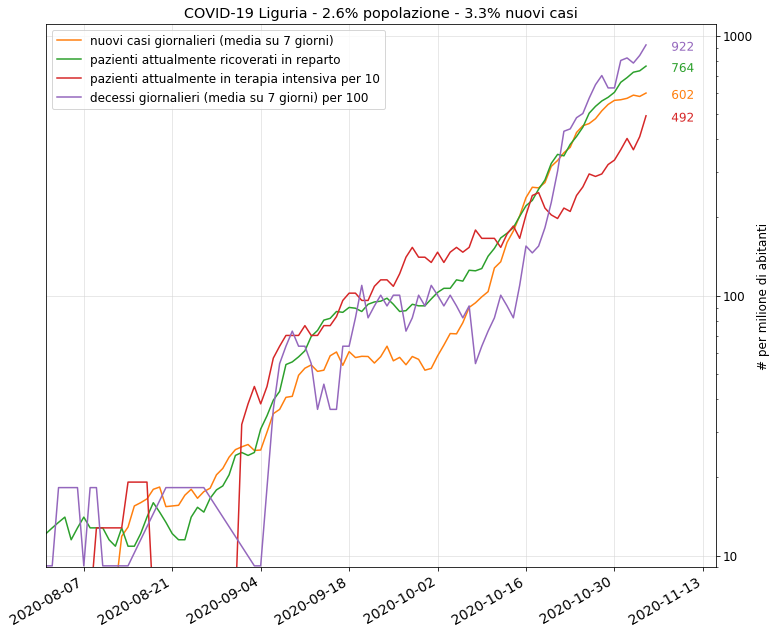

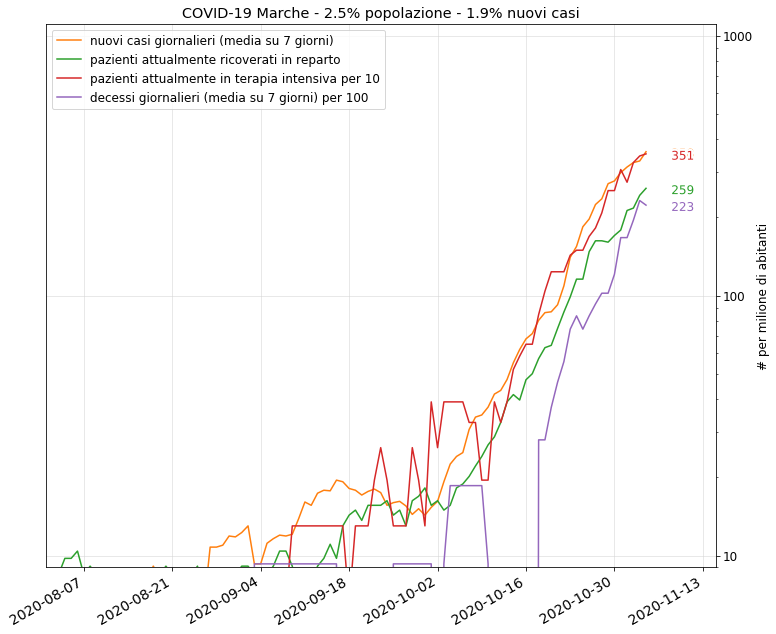

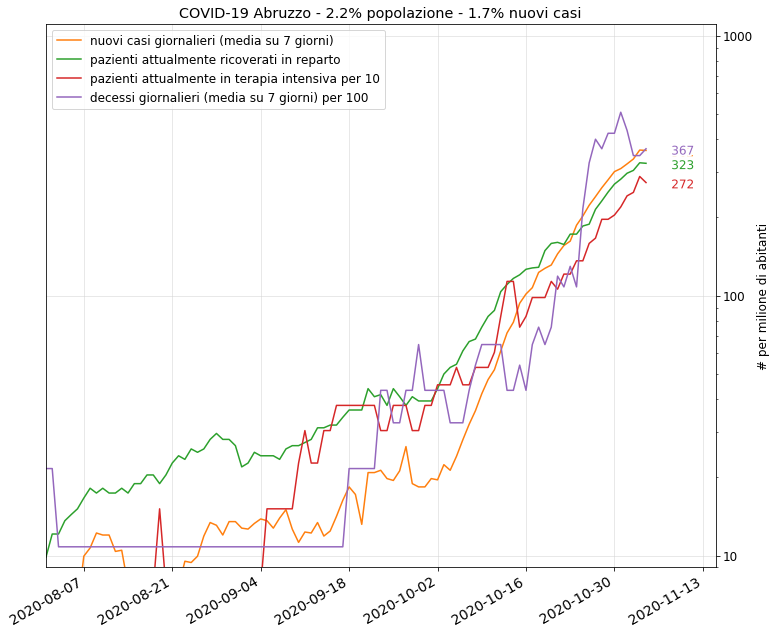

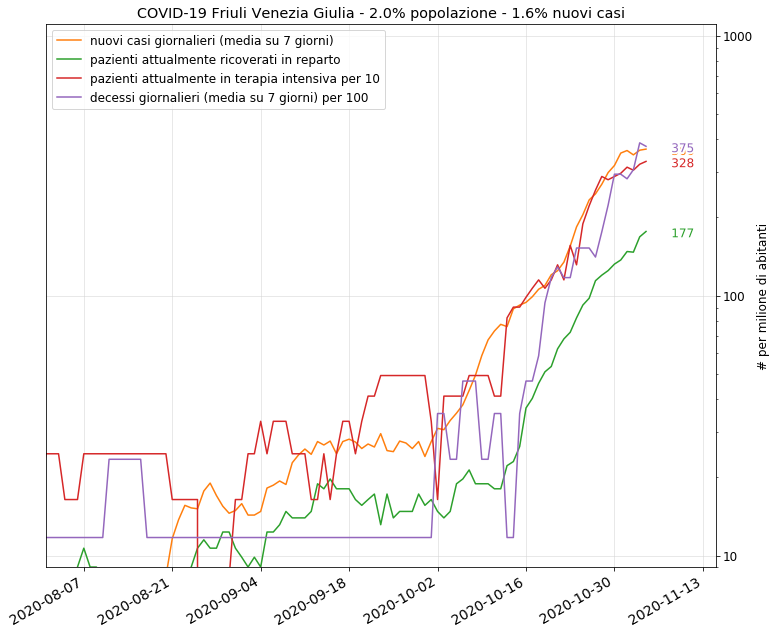

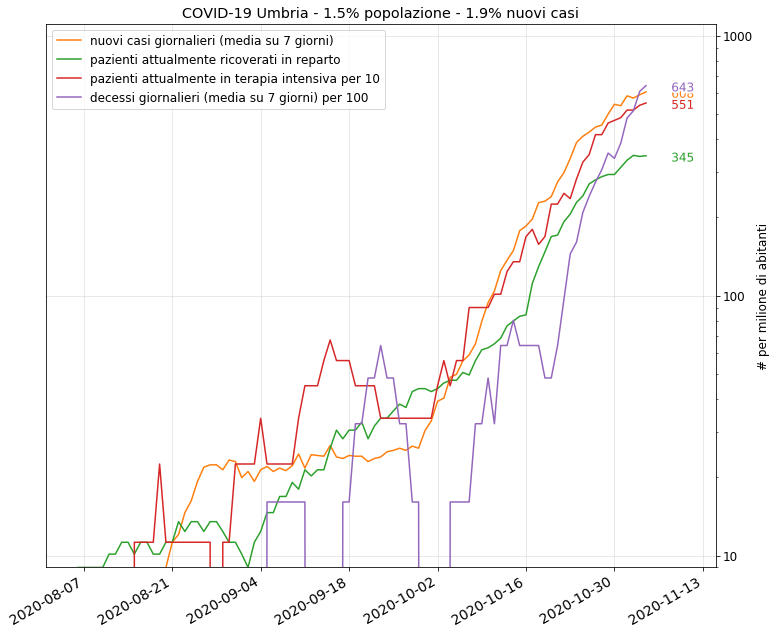

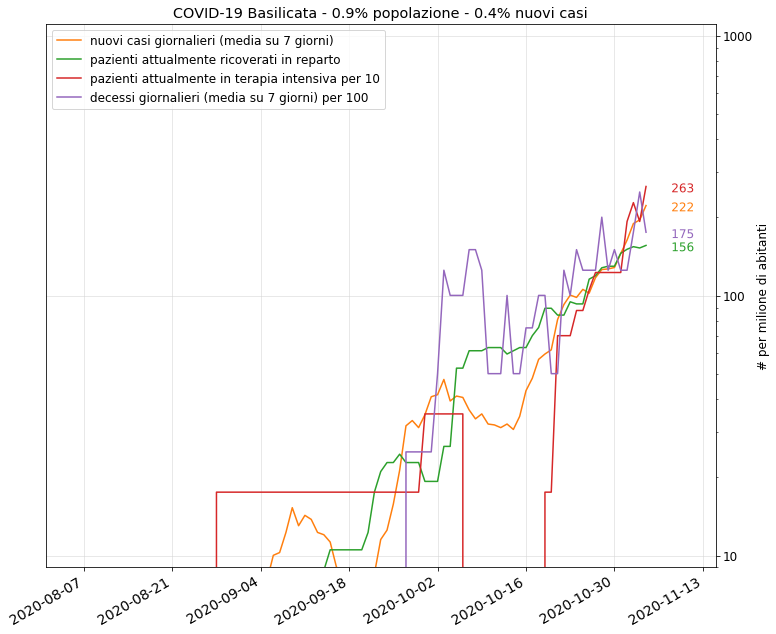

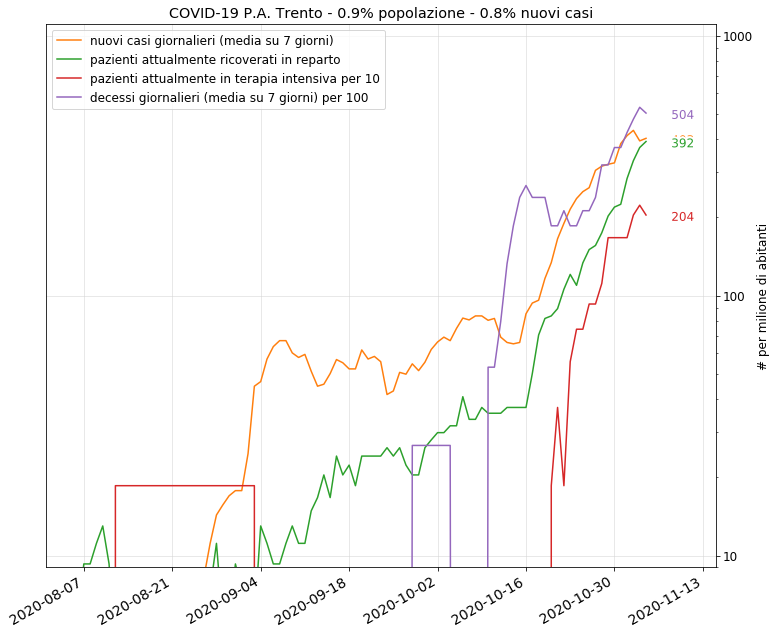

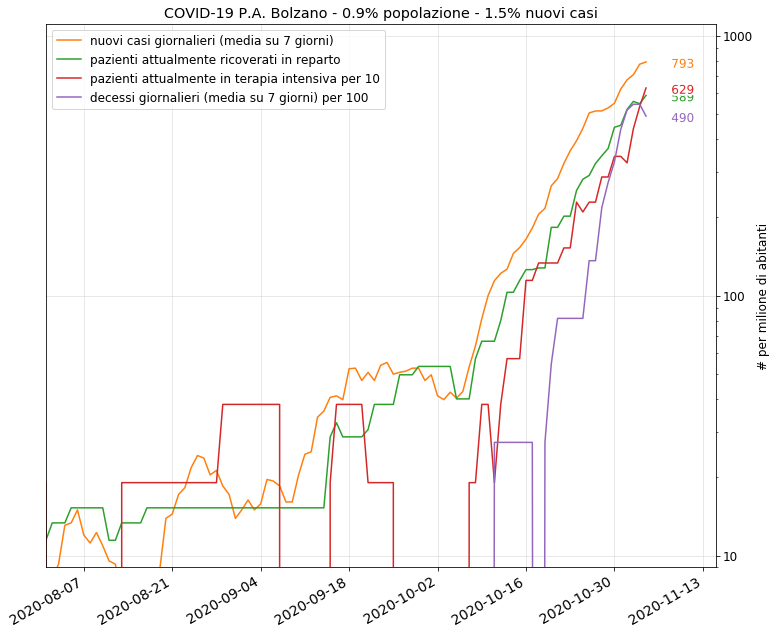

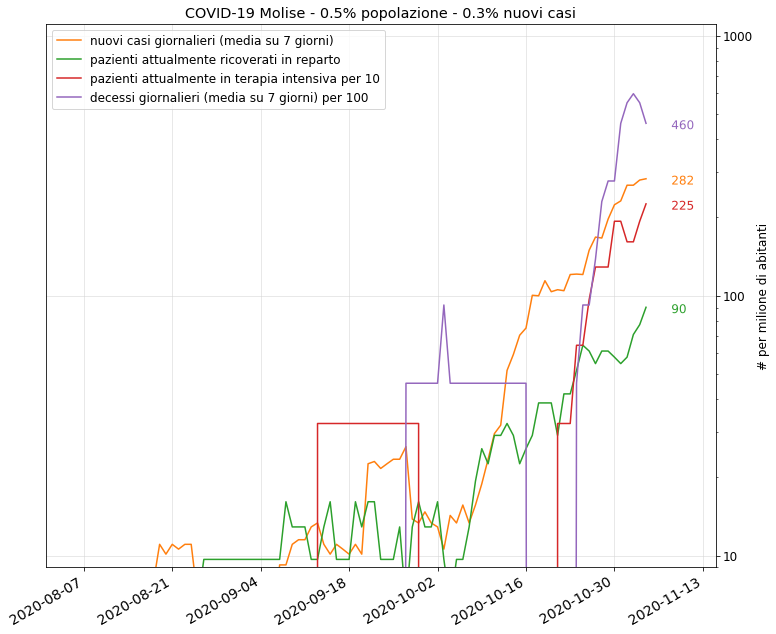

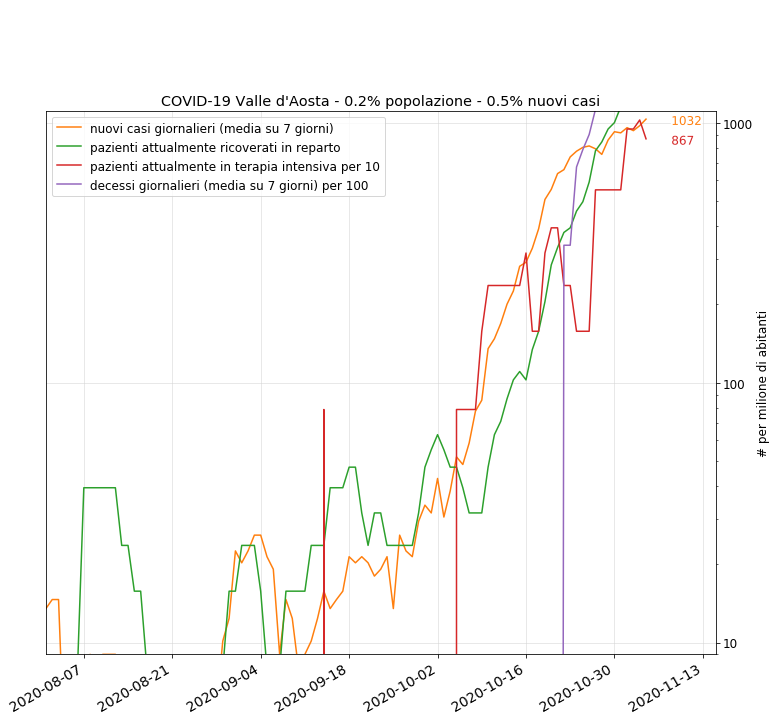

In [471]:
SHOW_REGIONS = {'daily_prevalence7', 'current_severe_pm','current_critical_pm', 'daily_mortality7'}

for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (10 * 0.9, 1000 / 0.9)})
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color, ratio in zip(fit_kinds.items(), PALETTE_ONE, [1, 1, 1, 10, 100]):
        if SHOW_REGIONS is not None and kind not in SHOW_REGIONS:
            continue

        label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio}'
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color, ratio=1 / ratio, marker=None, date_interval=14, annotate=True)
        #for fit in fitsk:
        #covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-7, 7], alpha=0.2)

    pop_perc = ds_region.population.values / ds_italy.population.values * 100
    pos_perc = ds_region['daily_confirmed7'][-1].values / ds_italy['daily_confirmed7'][-1].values * 100
    ax.set_title(f'COVID-19 {region} - {pop_perc:.1f}% popolazione - {pos_perc:.1f}% nuovi casi' )
    ax.set(xlabel="", ylabel="# per milione di abitanti")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.legend(loc='upper left')


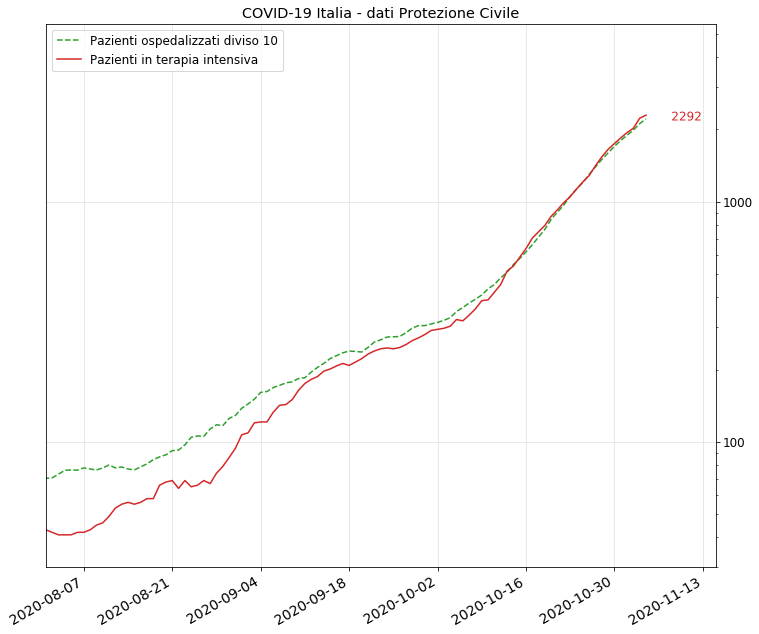

In [457]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'xlim': XLIM, 'ylim': (30, 5500)})
covid19.plot.plot_data(ax, ds_italy['current_severe'], marker=None, ratio=10, label='Pazienti ospedalizzati diviso 10', color='tab:green', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, label='Pazienti in terapia intensiva', color='tab:red', date_interval=14, annotate=True)
_ = ax.legend(loc='upper left')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

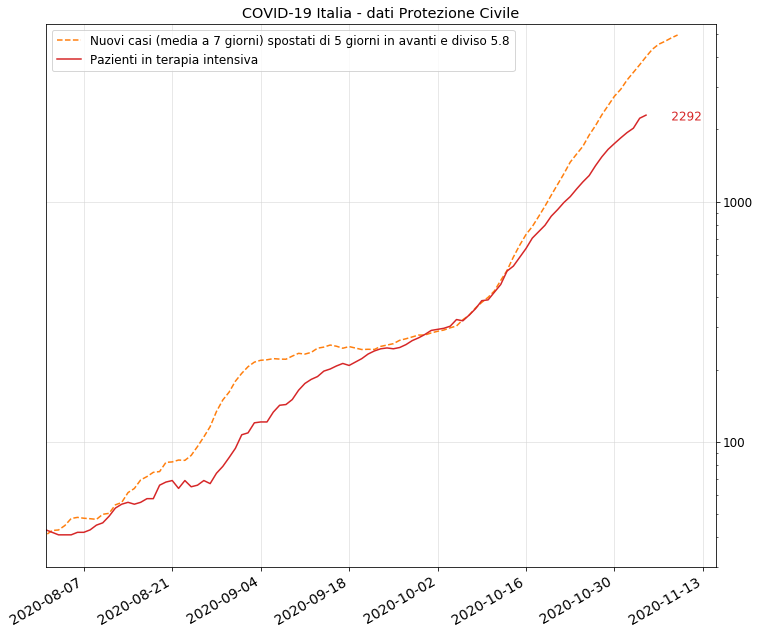

In [458]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'xlim': XLIM, 'ylim': (30, 5500)})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=5, ratio=5.8, label='Nuovi casi (media a 7 giorni) spostati di 5 giorni in avanti e diviso 5.8', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, label='Pazienti in terapia intensiva', color='tab:red', date_interval=14, annotate=True)
_ = ax.legend(loc='upper left')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

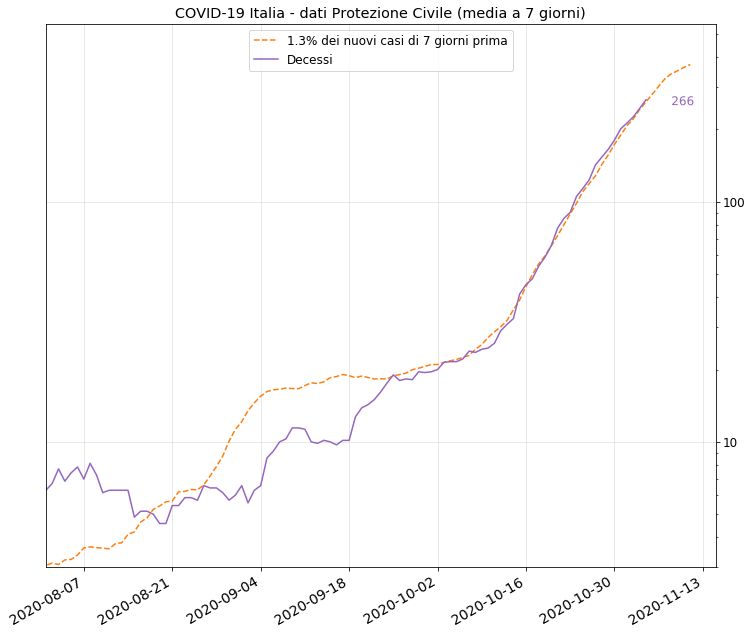

In [459]:
shift = 7
scale = 0.013

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (3, 550)})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=shift, ratio=1/scale, label=f'{scale * 100:.2g}% dei nuovi casi di {shift} giorni prima', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Decessi', color='tab:purple', date_interval=14, annotate=True)
# covid19.plot.plot_fit(ax, fits['daily_deaths7'][-1], marker=None, color='tab:purple', extrapolate=(-4, 7), label='stima')
_ = ax.legend(loc='upper center')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile (media a 7 giorni)', ylabel='', xlabel='')

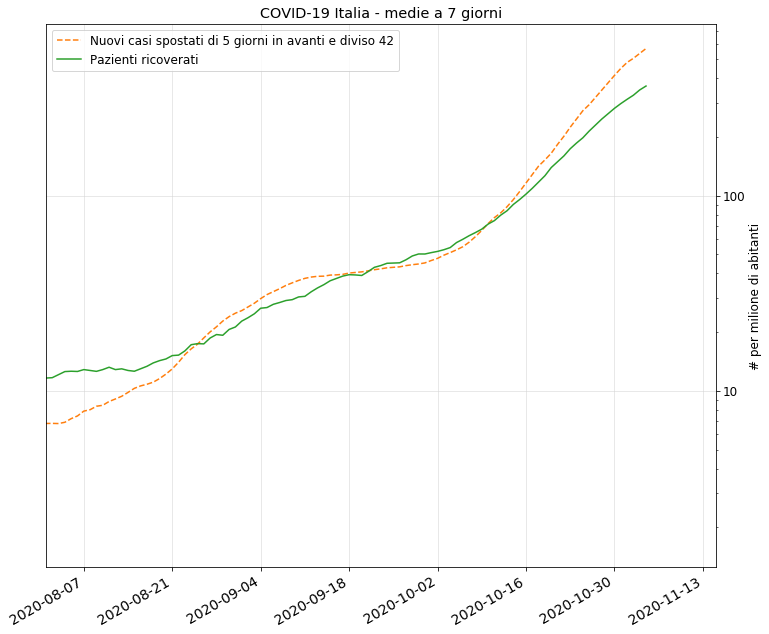

In [460]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed14'], marker=None, delay=0, ratio=35, label='Nuovi casi spostati di 5 giorni in avanti e diviso 42', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_severe_pm'], marker=None, label='Pazienti ricoverati', color='tab:green', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='# per milione di abitanti', xlabel='')

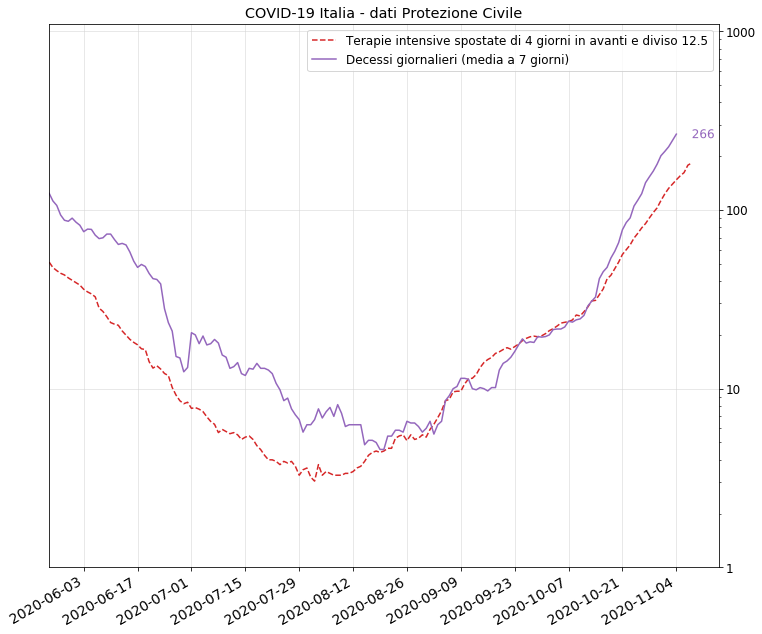

In [461]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': (np.datetime64('2020-05-25'), np.datetime64('2020-11-15')), 'yscale': 'log', 'ylim': (1, 1100)})
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, delay=4, ratio=12.5, label='Terapie intensive spostate di 4 giorni in avanti e diviso 12.5', color='tab:red', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Decessi giornalieri (media a 7 giorni)', color='tab:purple', date_interval=14, annotate=True)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

NameError: name 'daily_confirmed_estimate' is not defined

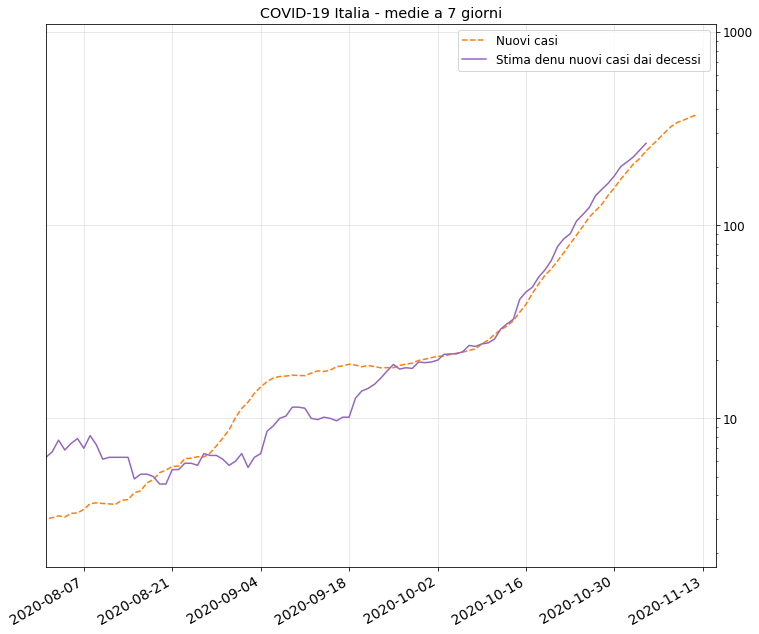

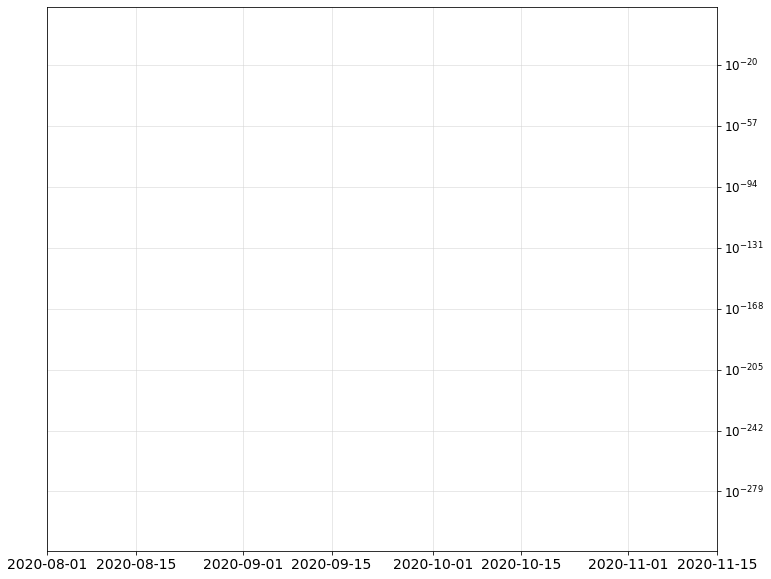

In [462]:
shift = 8
scale = 0.013

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], delay=shift, ratio=1/scale, marker=None, label='Nuovi casi', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Stima denu nuovi casi dai decessi ', color='tab:purple', date_interval=14)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='', xlabel='')

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, daily_confirmed_estimate / ds_italy['daily_confirmed7'], marker=None, label='Decessi giornalieri', color='tab:purple', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

In [ ]:
ds_italy.to_dataframe().head(40)

In [ ]:
ds_italy.to_dataframe().tail(60)

In [ ]:
da = ds_italy['current_critical'][159:]
for i in range(20):
    old = ds_italy['current_critical'][i]
    new = da[(da < old).argmin()]
    print(str(old.time.values)[:10], old.values, ds_italy['daily_deaths'].sel(time=old.time.values).values, str(new.time.values)[:10], new.values)

In [ ]:
daa = ds_italy['current_critical']
for i in range(10):
    try:
        new = da[i * 7 + 3]
    except:
        new = da[-1]
    # print(new, daa.values, (daa > new).values)
    old = daa[(daa <= new).argmin() - 1]
    old1 = daa[(daa <= new).argmin()]
    print(
        str(old.time.values)[:10],
        old.values,
        ds_italy['daily_deaths'].sel(time=old.time.values).values,
        ds_italy['current_severe'].sel(time=old.time.values).values,
        str(new.time.values)[:10],
        new.values,
        ds_italy['daily_deaths'].sel(time=new.time.values).values,
        ds_italy['current_severe'].sel(time=new.time.values).values,
    )

In [ ]:
daa

In [ ]:
a = xr.DataArray(
    [56, 64, 105, 140, 166, 229, 295, 351, 462, 567, 650, 733],
    dims=['time'],
    coords={
        'time': ('time', [np.datetime64(t) for t in ['2020-08-18', '2020-08-25', '2020-09-01', '2020-09-08', '2020-09-15', '2020-09-22', '2020-09-29', '2020-10-06', '2020-10-13', '2020-10-20', '2020-10-27', '2020-11-03']]),
        'old_time': ('time', ['2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09']),
    }
)
a

In [ ]:
# import matplotlib.patheffects as patheffects

f, ax = covid19.plot.subplots()
covid19.plot.plot_data(ax, da, marker=None, color='tab:red')
# covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'][159:], marker=None, delay=18, ratio=4.6, label='Nuovi casi spostati di 18 giorni in avanti e diviso 4.5', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, a, linestyle='', color='black')
for xp, l in zip(a.time.values, a.old_time.values):
    yp = a.sel(time=xp).values
    ax.annotate(l, (xp - 3 * np.timedelta64(1, 'D'), yp + 10), path_effects=[
                patheffects.Stroke(linewidth=4, foreground='white'),
                patheffects.Normal(),
            ])
ax.set(title='COVID-19 pazienti in terapia intensiva', xlabel='', ylim=(0, 820))

In [ ]:
f, ax = covid19.plot.subplots()
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, color='tab:red', date_interval=14)
ax.set(
    ylim=(0, 500),
)
for i in range(10):
    b = ds_italy['current_critical'][i + 2]
    c = da[(da < b).argmin()]
    ax.plot([b.time.values, c.time.values + 3 * np.timedelta64(day=1)], [b.values, b.values], color='tab:red')



In [ ]:
import math

peak_infected_percent = .6
peak_infected = peak_infected_percent * ds_italy.population.values
IFR_base = .006

T_ds_up = [7, 10, 20, 30]

print(f"{peak_infected:,.0f} {peak_infected * IFR_base:,.0f}")

In [ ]:
def Rt(T_d=7, onset_day=5):
    return 2 ** (onset_day / T_d)

print(f"{Rt():.2f}")

In [ ]:
1.64*.8

In [ ]:
2 ** ((t - t_0) / T_d)

T_d / ln(2) * 2 ** ((t - t_0) / T_d) + C

peak_infected = T_d / ln(2) * 2 ** ((t - t_0) / T_d)

ln2(peak_infected * ln(2) / T_d) * T_d = (t - t_0)

In [ ]:
def delta_time(T_d, peak_infected):
    return math.log2(peak_infected * math.log(2) / T_d) * T_d

delta_time(7, peak_infected)

In [ ]:
7 / math.log(2) * 2 ** ((152.5) / 7)

In [ ]:
cumul = 0
T_d = 7
for d in range(500):
    infected = 2 ** ((d + 107.5066) / T_d)
    cumul += infected
    theory = T_d / math.log(2) * 2 ** (d / T_d)
    print(f"{d} {np.datetime64('2020-10-25') + d * DAY:.10s} {infected/2:,.0f} {infected:,.0f} {cumul + 3458000:,.0f}")


In [372]:
ds_italy['daily_confirmed'].sel(time=slice('2020-06-01')).sum().values * 2 + 3000000

3465936.0

In [401]:
def approx_tot(T_d):
    for d in range(100, 160):
        print(f"{np.datetime64('2020-07-16') + d * DAY:.10s} {d - 100} {2 ** (d / T_d):,.0f} {T_d / math.log(2) * 2 ** (d / T_d) + 3_500_000:,.0f}")
approx_tot(7)

2020-10-24 0 19,972 3,701,698
2020-10-25 1 22,051 3,722,692
2020-10-26 2 24,347 3,745,872
2020-10-27 3 26,881 3,771,465
2020-10-28 4 29,679 3,799,722
2020-10-29 5 32,768 3,830,920
2020-10-30 6 36,179 3,865,365
2020-10-31 7 39,945 3,903,396
2020-11-01 8 44,102 3,945,385
2020-11-02 9 48,693 3,991,745
2020-11-03 10 53,761 4,042,930
2020-11-04 11 59,358 4,099,443
2020-11-05 12 65,536 4,161,839
2020-11-06 13 72,358 4,230,730
2020-11-07 14 79,889 4,306,791
2020-11-08 15 88,205 4,390,770
2020-11-09 16 97,386 4,483,489
2020-11-10 17 107,523 4,585,860
2020-11-11 18 118,715 4,698,887
2020-11-12 19 131,072 4,823,678
2020-11-13 20 144,715 4,961,460
2020-11-14 21 159,779 5,113,582
2020-11-15 22 176,410 5,281,539
2020-11-16 23 194,772 5,466,979
2020-11-17 24 215,046 5,671,720
2020-11-18 25 237,430 5,897,774
2020-11-19 26 262,144 6,147,357
2020-11-20 27 289,430 6,422,919
2020-11-21 28 319,557 6,727,164
2020-11-22 29 352,820 7,063,078
2020-11-23 30 389,544 7,433,957
2020-11-24 31 430,092 7,843,441
202